In [1]:
import cmiles
from openeye import oechem
from rdkit import Chem
import oenotebook as oenb
import pandas as pd

In [8]:
def check_is_stereo_oe(smiles):
    molecule = oechem.OEMol()
    oechem.OESmilesToMol(molecule, smiles)
    unspec_chiral = False
    unspec_db = False
    problematic_atoms = list()
    problematic_bonds = list()
    for atom in molecule.GetAtoms():
        if atom.IsChiral() and not atom.HasStereoSpecified(oechem.OEAtomStereo_Tetrahedral):
            # Check if handness is specified
            v = []
            for nbr in atom.GetAtoms():
                v.append(nbr)
            stereo = atom.GetStereo(v, oechem.OEAtomStereo_Tetrahedral)
            if stereo == oechem.OEAtomStereo_Undefined:
                unspec_chiral = True
                problematic_atoms.append((atom.GetIdx(), oechem.OEGetAtomicSymbol(atom.GetAtomicNum())))
    for bond in molecule.GetBonds():
        if bond.IsChiral() and not bond.HasStereoSpecified(oechem.OEBondStereo_CisTrans):
            v = []
            for neigh in bond.GetBgn().GetAtoms():
                if neigh != bond.GetEnd():
                    v.append(neigh)
                    #break
            for neigh in bond.GetEnd().GetAtoms():
                if neigh != bond.GetBgn():
                    v.append(neigh)
                    #break
            stereo = bond.GetStereo(v, oechem.OEBondStereo_CisTrans)

            if stereo == oechem.OEBondStereo_Undefined:
                unspec_db = True
                a1 = bond.GetBgn()
                a2 = bond.GetEnd()
                a1_idx = a1.GetIdx()
                a2_idx = a2.GetIdx()
                a1_s = oechem.OEGetAtomicSymbol(a1.GetAtomicNum())
                a2_s = oechem.OEGetAtomicSymbol(a2.GetAtomicNum())
                bond_order = bond.GetOrder()
                problematic_bonds.append((a1_idx, a1_s, a2_idx, a2_s, bond_order))
    if unspec_chiral or unspec_db:
        print("Stereochemistry is unspecified. Problematic atoms {}, problematic bonds {}".format(problematic_atoms,
                                                                                                             problematic_bonds))
        return False
    else:
        return True

def check_is_stereo_rd(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    unspec_chiral = False
    unspec_bond = False
    chiral_centers = Chem.FindMolChiralCenters(molecule, includeUnassigned=True)
    for center in chiral_centers:
        atom_id = center[0]
        if center[-1] == '?':
            unspec_chiral = True
            print("unspecified chirality {}".format(molecule.GetAtomWithIdx(atom_id).GetSmarts()))
    Chem.FindPotentialStereoBonds(molecule)
    for bond in molecule.GetBonds():
        if bond.GetStereo() == Chem.BondStereo.STEREOANY:
            unspec_bond = True
            print("usnpecified bond {}".format(bond.GetBeginAtom().GetSmarts(), bond.GetSmarts(),
                                                        bond.GetEndAtom().GetSmarts()))
    if unspec_chiral or unspec_bond:
        return False
    else:
        return True
    
def fix_stereo_oe(smiles):
    mol = oechem.OEMol()
    oechem.OESmilesToMol(mol, smiles)
    for atom in mol.GetAtoms():
        if atom.IsChiral() and not atom.HasStereoSpecified(oechem.OEAtomStereo_Tetrahedral):
            v = []
            for neigh in atom.GetAtoms():
                v.append(neigh)
            atom.SetStereo(v, oechem.OEAtomStereo_Tetra, oechem.OEAtomStereo_Left)
    for bond in mol.GetBonds():
        if bond.GetOrder() == 2 and not bond.HasStereoSpecified(oechem.OEBondStereo_CisTrans):
            v = []
            for neigh in bond.GetBgn().GetAtoms():
                if neigh != bond.GetEnd():
                    v.append(neigh)
                    break
            for neigh in bond.GetEnd().GetAtoms():
                if neigh != bond.GetBgn():
                    v.append(neigh)
                    break
            bond.SetStereo(v, oechem.OEBondStereo_CisTrans, oechem.OEBondStereo_Trans)
    return (oechem.OEMolToSmiles(mol))


In [10]:
problematic_smiles = []
with open('../cmiles/tests/reference/drug_bank_sm.smi') as f:
    smiles_name = f.read().split('\n')
smiles = []
for sm in smiles_name:
    smiles.append(sm.split(' ')[0])

problematic_smiles_oe = []
problematic_smiles_rd = []
indices_oe = []
indices_rd = []
only_rd_caught = []
only_oe_caught = []
for i, sm in enumerate(smiles):
    oe_caught = False
    rd_caught = False
    if not check_is_stereo_oe(sm):
        oe_caught = True
        problematic_smiles_oe.append(sm)
        indices_oe.append(i)
    if not check_is_stereo_rd(sm):
        rd_caught = True
        problematic_smiles_rd.append(sm)
        indices_rd.append(i)
    if oe_caught and not rd_caught:
        only_oe_caught.append(sm)
    if rd_caught and not oe_caught:
        only_rd_caught.append(sm)

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(94, 'C', 96, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(71, 'C', 73, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(92, 'C', 94, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(18, 'N'), (57, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(9, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(5, 'S')], problematic bonds []
unspecified chirality [S+]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(7, 'C', 9, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(16, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'C', 8, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(17, 'P'), (21, 'P')], proble

Stereochemistry is unspecified. Problematic atoms [(7, 'C'), (11, 'C'), (14, 'C'), (28, 'C'), (31, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
unspecified chirality C
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(4, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(4, 'C'), (6, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(9, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(5, 'C')], problematic bonds []
unspecified chiral

Stereochemistry is unspecified. Problematic atoms [(18, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(5, 'C'), (7, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(4, 'C'), (7, 'C'), (14, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(9, 'N', 10, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [(30, 'C'), (42, 'N'), (59, 'N'), (73, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality [N+]
unspecified chirality [N+]
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds [(3, 'C', 4, 'C', 2)]
usnpecified bond C
Stereochemistry is unspecified. Proble

Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(23, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(14, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'C', 7, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(34, 'C', 36, 'N', 2), (43, 'C', 45, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(14, 'N'), (18, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(6, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(13, 'C')], problemat

Stereochemistry is unspecified. Problematic atoms [(4, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(15, 'C'), (19, 'N')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(11, 'N'), (23, 'C'), (27, 'N')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(8, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(2, 'C'), (9, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(2, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(5, 'C'), (8, 'N'), (17, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(6,

Stereochemistry is unspecified. Problematic atoms [(5, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(28, 'N', 29, 'C', 2), (32, 'C', 34, 'N', 2)]
usnpecified bond N
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(7, 'C', 8, 'N', 2), (13, 'C', 15, 'N', 2), (21, 'C', 23, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(41, 'N', 42, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [(18, 'P'), (22, 'P')], problematic bonds [(3, 'C', 5, 'N', 2), (8, 'C', 10, 'N', 2)]
unspecified chirality P
unspecified chirality P
usnpecified bond C
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(17, 'N', 18, 'C', 2), (21, 'C', 23, 'N', 2), (44, 'C', 46, 'N', 2)]
usnpecified bond N
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(16, 'P')], problematic bonds []


Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(7, 'C', 8, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(36, 'C', 38, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(35, 'P'), (39, 'P')], problematic bonds [(3, 'C', 5, 'N', 2), (8, 'C', 10, 'N', 2)]
unspecified chirality P
unspecified chirality P
usnpecified bond C
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(1, 'C'), (29, 'P'), (58, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality P
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(13, 'N'), (15, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(23, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(20, 'C', 22, 'N', 2), (29, 'C', 31, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bond

Stereochemistry is unspecified. Problematic atoms [(11, 'N')], problematic bonds [(35, 'C', 36, 'O', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(3, 'O'), (14, 'O')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(22, 'C', 24, 'N', 2), (30, 'C', 32, 'N', 2), (50, 'C', 52, 'N', 2), (58, 'C', 60, 'N', 2)]
usnpecified bond C
usnpecified bond C
usnpecified bond C
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(5, 'C', 7, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(6, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(4, 'P'), (8, 'P')], problematic bonds []
unspecified chirality P
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(10, 'C', 12, 'N', 2), (41, 'C', 43, 'N', 2)]
usnpecified bond C
usnpecified bond C
Stereochemistry is unsp

Stereochemistry is unspecified. Problematic atoms [(12, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(3, 'C', 4, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(16, 'N'), (31, 'N')], problematic bonds [(24, 'C', 26, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(21, 'C', 23, 'N', 2), (33, 'C', 35, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(26, 'C', 28, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(14, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(3, 'N', 4, 'C', 2), (7, 'C', 9, 'N', 2)]
usnpecified bond N
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(16, 'N', 17, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(7, 

Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'N', 7, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [(4, 'P'), (8, 'P')], problematic bonds [(24, 'C', 26, 'N', 2)]
unspecified chirality P
unspecified chirality P
unspecified chirality [Fe]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(15, 'N', 16, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(15, 'C', 17, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(8, 'P'), (12, 'P')], problematic bonds []
unspecified chirality P
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(11, 'N'), (13, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(5, 'P'), (9, 'P')], problematic bonds []
unspecified chirality P
unspecified chirality P
Stereochemistry is unspeci

Stereochemistry is unspecified. Problematic atoms [(12, 'P'), (16, 'P'), (20, 'P'), (24, 'P'), (28, 'P')], problematic bonds []
unspecified chirality P
unspecified chirality P
unspecified chirality P
unspecified chirality P
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(71, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(8, 'N', 9, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(5, 'C', 7, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(3, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(5, 'C', 7, 'N', 2), (23, 'C', 25, 'N', 2)]
usnpecified bond C
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(15, 'N')], problematic bonds [(5, 'C', 7, 'N', 2), (24, 'C', 26, 'N',

Stereochemistry is unspecified. Problematic atoms [(6, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(9, 'C', 11, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(15, 'N', 16, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(1, 'C', 2, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(15, 'C', 16, 'C', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(16, 'C', 18, 'N', 2), (41, 'C', 43, 'N', 2), (49, 'C', 51, 'N', 2)]
usnpecified bond C
usnpecified bond C
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(17, 'N'), (19, 'N')], problematic bonds [(24, 'C', 25, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(42, 'N', 43, 'C', 2), (51, 'N', 52, 'C', 2), (60, 'N', 61, 'C', 2)]
usnpecified bond N
usnpecified bond N
usnpecified bond N
Ste

Stereochemistry is unspecified. Problematic atoms [(6, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(4, 'C')], problematic bonds [(14, 'N', 15, 'C', 2), (19, 'N', 20, 'C', 2), (24, 'N', 25, 'C', 2)]
unspecified chirality C
usnpecified bond N
usnpecified bond N
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [(10, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(4, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(14, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(46, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(38, 'C', 40, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(23, 'C'

Stereochemistry is unspecified. Problematic atoms [(14, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(3, 'C'), (6, 'C'), (7, 'C'), (8, 'C'), (14, 'C'), (15, 'C'), (20, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
unspecified chirality C
unspecified chirality C
unspecified chirality C
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(14, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(5, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(5, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(3, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(6, 'N'), (11, 'P'), (16, 'P'), (21, 'P')], problematic bonds []
unspecified chirality P
unspecified chirality P
unspecified chirality P
Stereoche

Stereochemistry is unspecified. Problematic atoms [(15, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(4, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(129, 'C', 131, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(16, 'C'), (20, 'N')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(4, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(2, 'N'), (6, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(8, 'N', 9, 'C', 2), (49, 'C', 51, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(18, 'C'), (20, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
Stereo

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(8, 'C', 10, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(8, 'C', 10, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(1, 'C', 2, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(2, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(1, 'C', 2, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(26, 'C', 28, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(6, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(18, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(11, 'C'), (12, 'C'), (24, 'C')], problematic bonds [(1, 'C', 8, 'C', 2)]
unspecified chirality C
unspecified chirality C
unspecified chiralit

Stereochemistry is unspecified. Problematic atoms [(4, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(3, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(3, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(4, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(2, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(1, 'N', 2, 'C', 2)]
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(16, 'C', 18, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(19, 'C', 21, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(6, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(6, 'P')], problematic bonds []
unspeci

Stereochemistry is unspecified. Problematic atoms [(4, 'C'), (8, 'N'), (10, 'N'), (12, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'C'), (14, 'C'), (28, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(21, 'C')], problematic bonds [(10, 'C', 11, 'N', 2)]
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds [(19, 'N', 20, 'C', 2)]
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(2, 'C', 4, 'N', 2)]
usnpecified bond C
unspecified chirality [N+]
Stereochemistry is unspecified. Problematic atoms [(1,

unspecified chirality C
unspecified chirality [N+]
Stereochemistry is unspecified. Problematic atoms [(1, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(1, 'N'), (4, 'N'), (5, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(12, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(30, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(3, 'C', 4, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(2, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(14, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(8, 'C', 9, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(1, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is

Stereochemistry is unspecified. Problematic atoms [(25, 'N'), (28, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(29, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(21, 'P')], problematic bonds []
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(0, 'N', 1, 'C', 2)]
Stereochemistry is unspecified. Problematic atoms [(6, 'P')], problematic bonds []
unspecified chirality [PH]
Stereochemistry is unspecified. Problematic atoms [(19, 'N'), (27, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'N', 7, 'C', 2), (20, 'N', 21, 'C', 2), (48, 'C', 50, 'N', 2)]
usnpecified bond N
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(4, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(11, 'C', 13, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Proble

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(3, 'N', 4, 'C', 2), (18, 'N', 19, 'C', 2)]
usnpecified bond N
usnpecified bond N
Stereochemistry is unspecified. Problematic atoms [(4, 'N'), (7, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(14, 'C'), (17, 'P')], problematic bonds []
unspecified chirality C
unspecified chirality P
Stereochemistry is unspecified. Problematic atoms [(23, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(1, 'C', 2, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(32, 'C'), (35, 'C'), (38, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [(2, 'C'), (16, 'C'), (39, 'C'), (50, 'C')], problematic bonds []
unspecified chirality C
unspecified chirality C
unspecified chirality C
unspecified chirality C
Stereochemistry is uns

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'C', 8, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(5, 'C', 7, 'N', 2), (1, 'C', 8, 'N', 2), (10, 'C', 12, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [(8, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [(11, 'N')], problematic bonds []
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(13, 'C', 21, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(13, 'C', 15, 'N', 2), (38, 'C', 40, 'N', 2)]
usnpecified bond C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(20, 'C', 21, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [(21, 'C')], problematic bonds []
unspecified chirality C
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(25, 'C', 27, 'N', 2)]
Stereochem

In [11]:
print(len(problematic_smiles_oe))
print(len(problematic_smiles_rd))
print(len(only_oe_caught))
print(len(only_rd_caught))

2020
1268
771
19


In [64]:
# Try fixing oe stereo
still_problematic_oe = []
still_problematic_rd = []
only_oe_caught_after_fix = []
only_rd_caught_after_fix = []
all_problems = list(set(problematic_smiles_oe + problematic_smiles_rd))
for sm in all_problems:
    oe_caught = False
    rd_caught = False
    fixed_sm = fix_stereo_oe(sm)
    # check stereo again
    if not check_is_stereo_oe(fixed_sm):
        oe_caught = True
        still_problematic_oe.append(fixed_sm)
    if not check_is_stereo_rd(fixed_sm):
        rd_caught = True
        still_problematic_rd.append(fixed_sm)
    if oe_caught and not rd_caught:
        only_oe_caught_after_fix.append(fixed_sm)
    if rd_caught and not oe_caught:
        only_rd_caught_after_fix.append(fixed_sm)
    

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(2, 'C', 3, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(4, 'C', 5, 'N', 2), (7, 'C', 8, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(13, 'C', 14, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(23, 'C', 24, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(15, 'C', 16, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(30, 'C', 31, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(26, 'C', 27, 'N', 2), (29, 'C', 30, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(42, 'C', 43, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(10, 'C', 11, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(3, 'C', 4, 'N', 2)]
St

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(153, 'C', 154, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(14, 'C', 15, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(9, 'C', 10, 'N', 2), (15, 'C', 16, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(0, 'C', 1, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(89, 'C', 90, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(1, 'C', 2, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(26, 'C', 27, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(0, 'C', 1, 'N', 2), (4, 'C', 5, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(48, 'C', 49, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(11, 'C', 12, 'N', 2)]
S

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(28, 'C', 29, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(25, 'C', 26, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(12, 'C', 13, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(21, 'C', 22, 'N', 2)]
unspecified chirality [Fe]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(12, 'C', 13, 'N', 2), (27, 'C', 28, 'N', 2), (39, 'C', 40, 'N', 2), (51, 'C', 52, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'C', 7, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(3, 'C', 4, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(21, 'C', 22, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(5, 'C', 6, 'N', 2)]
Stereochemistry is unspecified. Problematic at

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(54, 'C', 55, 'N', 2)]
unspecified chirality [N+]
unspecified chirality [Gd-]
unspecified chirality [N+]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(22, 'C', 23, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(100, 'C', 101, 'N', 2), (270, 'C', 271, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(13, 'C', 14, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(49, 'C', 50, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(12, 'C', 13, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(16, 'C', 17, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'C', 7, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(6, 'C', 7, 'N', 2)]
Stereochemistry is unspecified.

Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(12, 'C', 13, 'N', 2)]
unspecified chirality P
unspecified chirality [Fe]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(0, 'C', 1, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(1, 'C', 2, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(21, 'C', 22, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(19, 'C', 20, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(36, 'C', 37, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(29, 'C', 30, 'N', 2)]
unspecified chirality [Fe]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(34, 'C', 35, 'N', 2), (48, 'C', 49, 'N', 2)]
Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(5, 'C', 6, 'N', 2)]
Stereochemistry is unspecified. Problemat

In [65]:
print(len(still_problematic_oe))
print(len(still_problematic_rd))
print(len(only_oe_caught_after_fix))
print(len(only_rd_caught_after_fix))

412
37
412
37



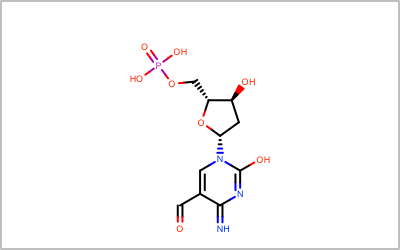
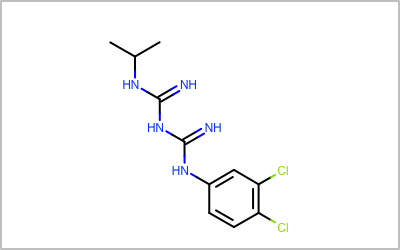
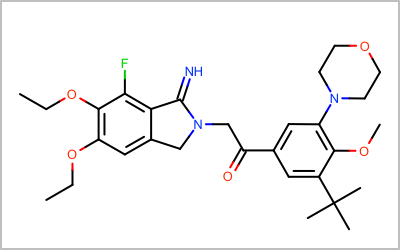
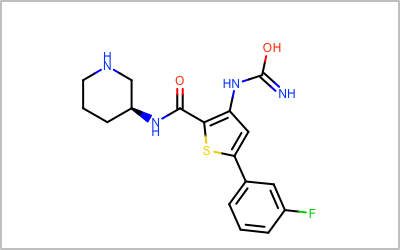
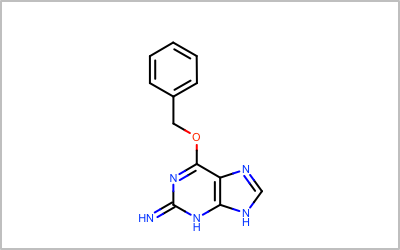
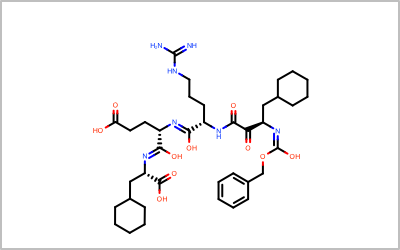
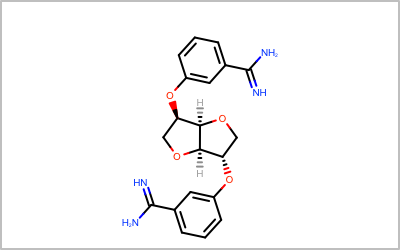
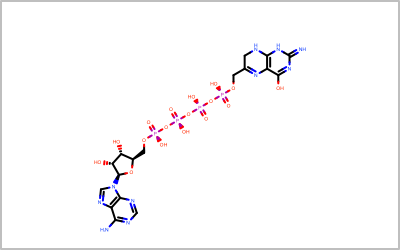
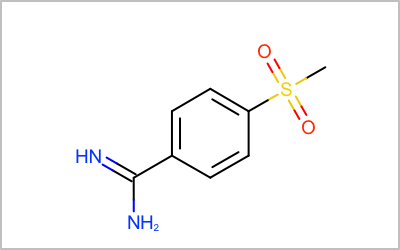
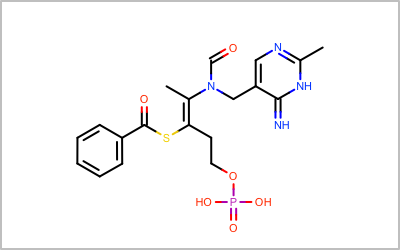
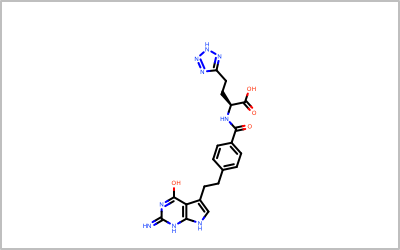
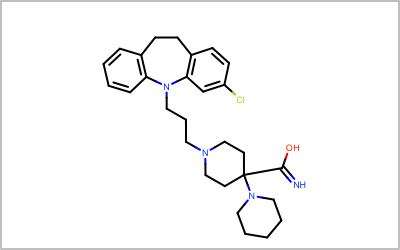
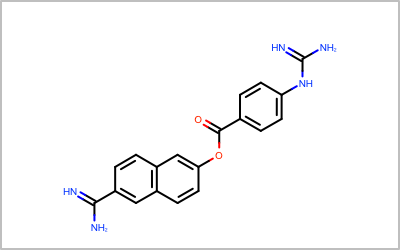
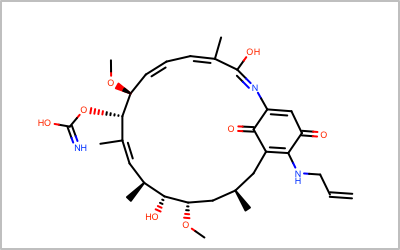
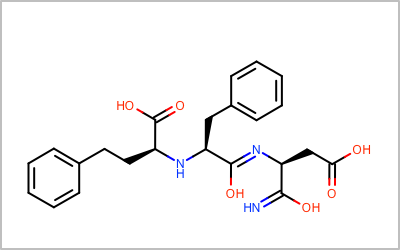
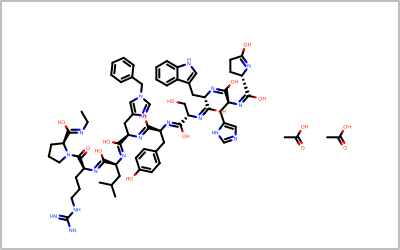
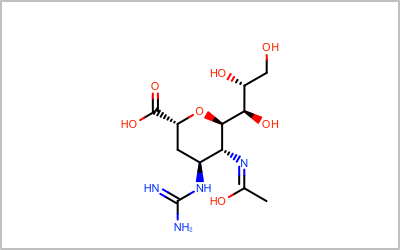
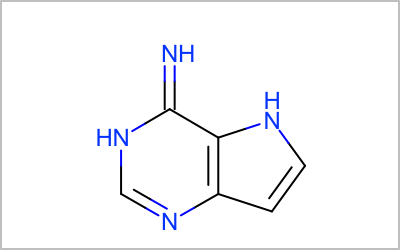
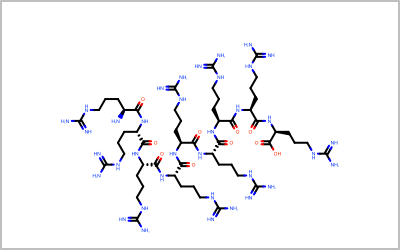
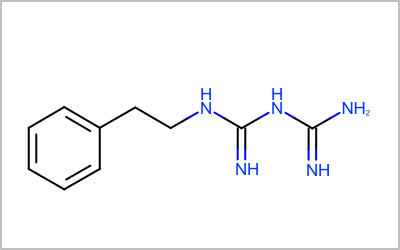
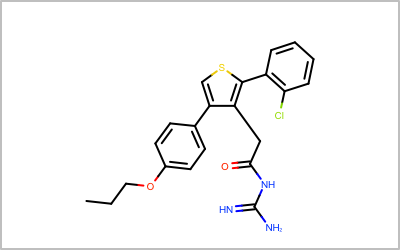
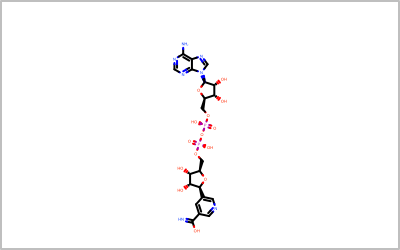
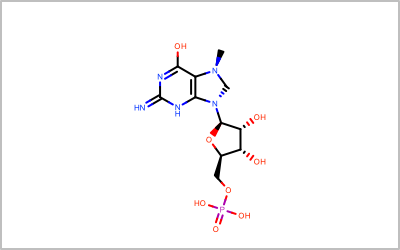
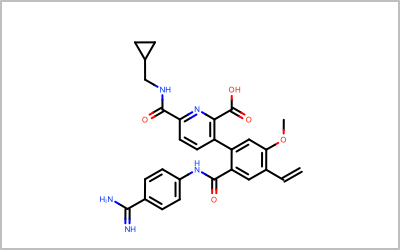
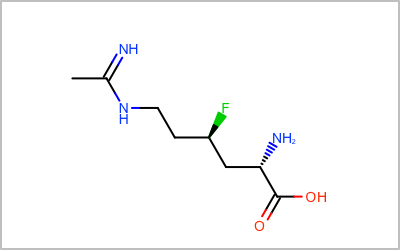
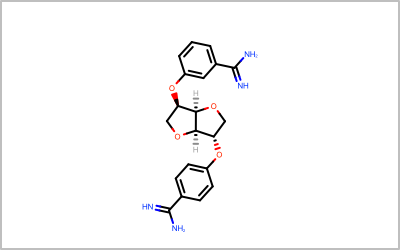
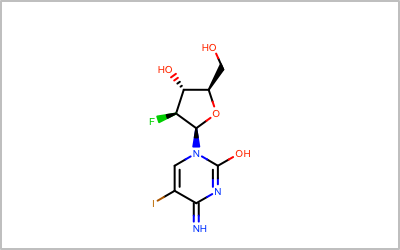
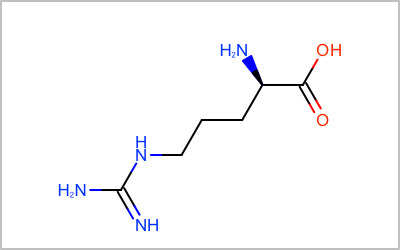
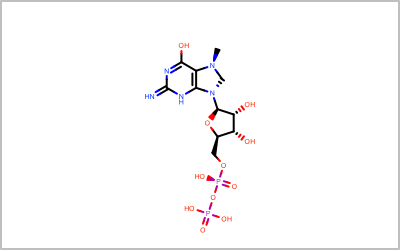
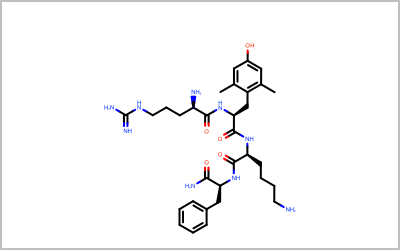
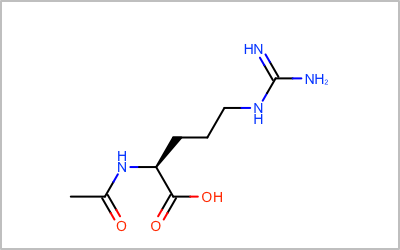
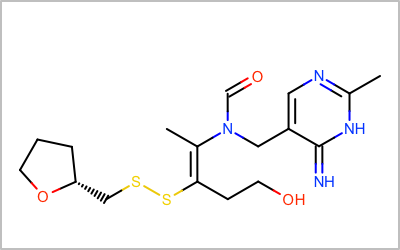
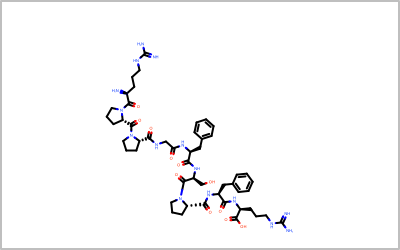
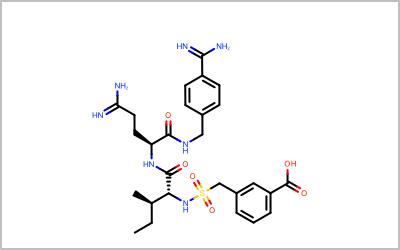
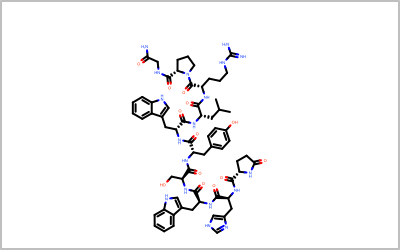
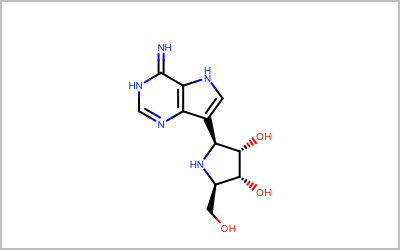
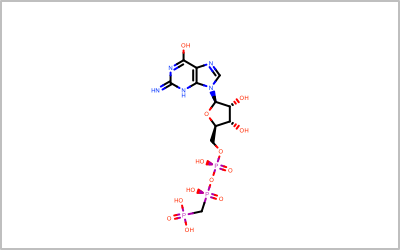
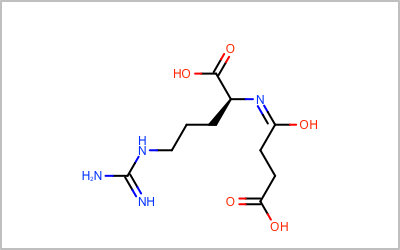
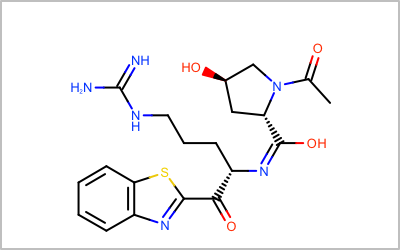
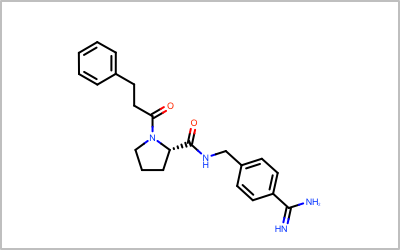
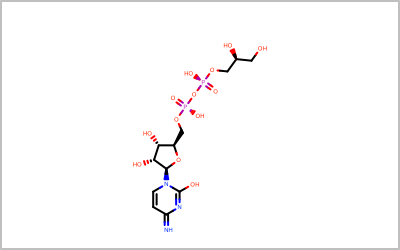
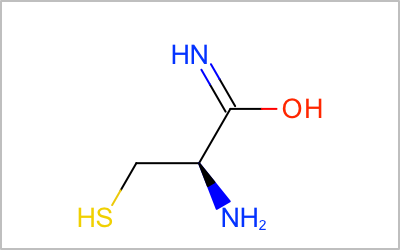
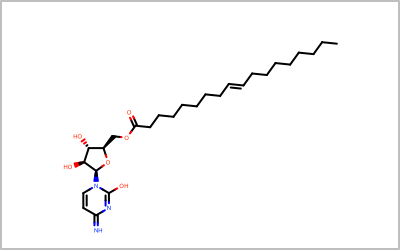
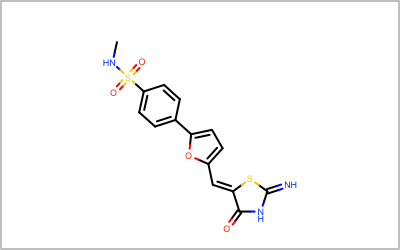
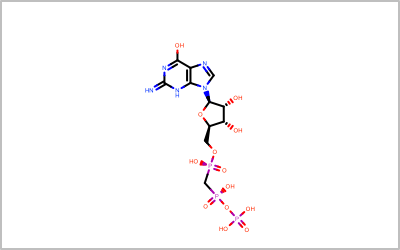
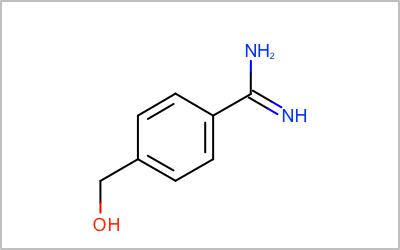
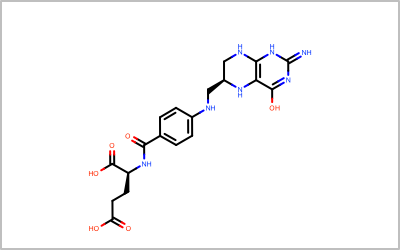
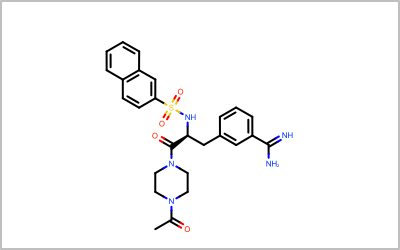
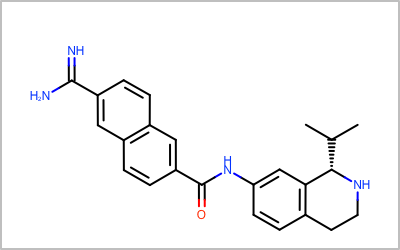
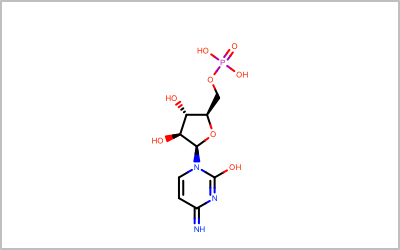
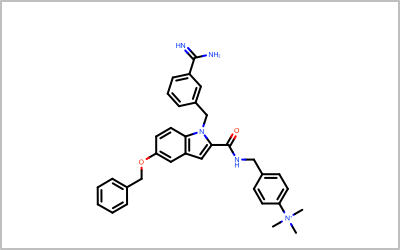
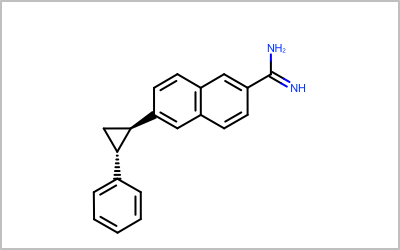
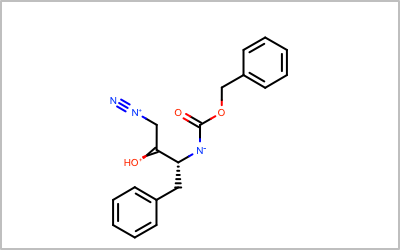
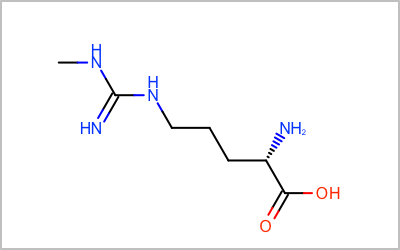
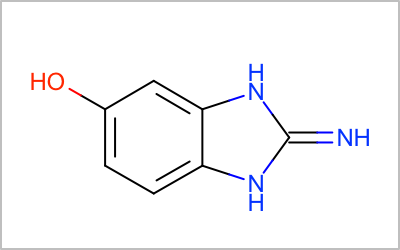
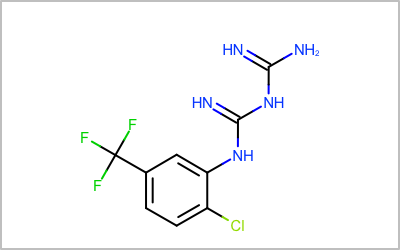
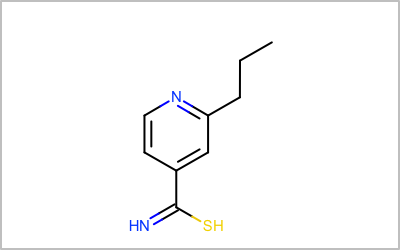
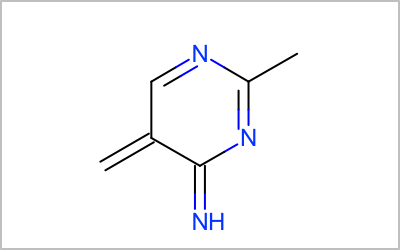
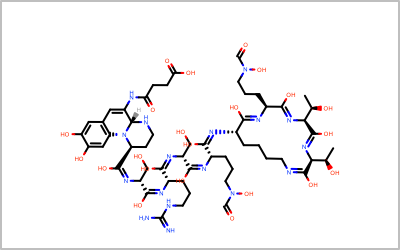
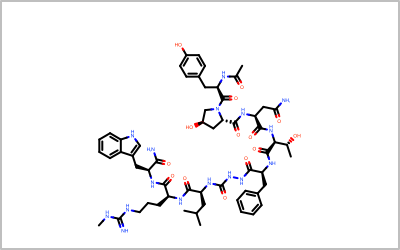
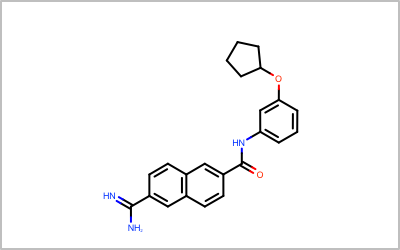
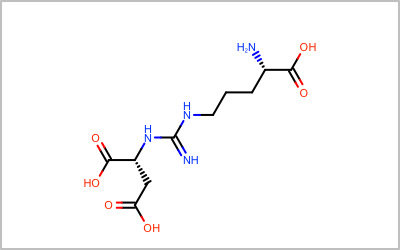
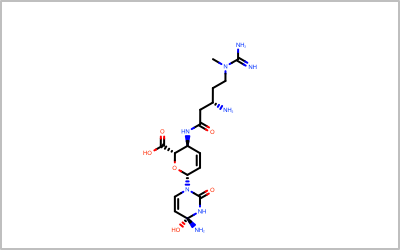
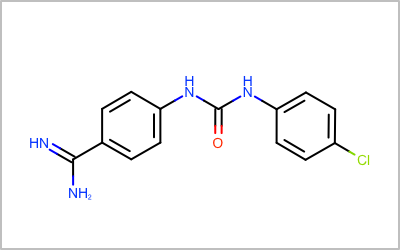
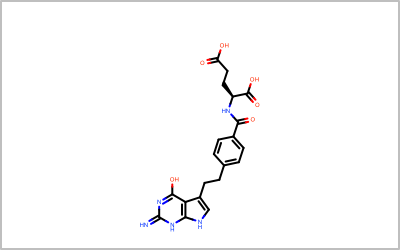
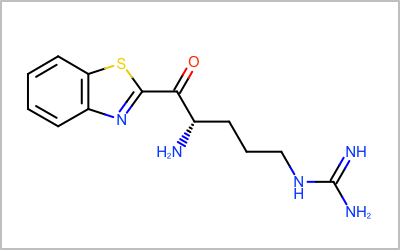
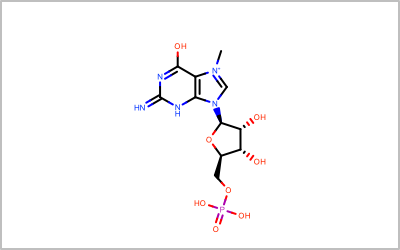
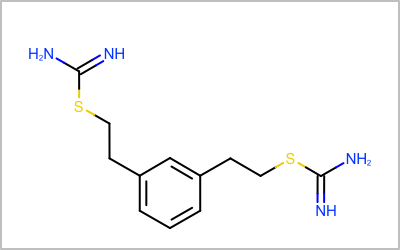
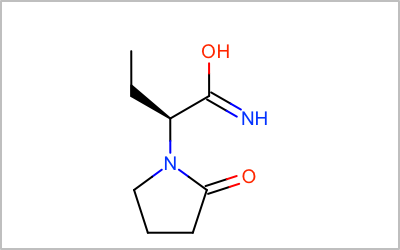
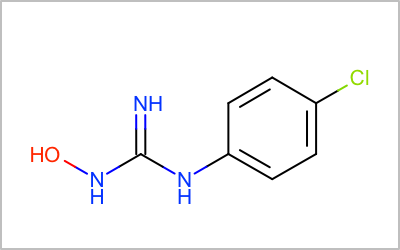
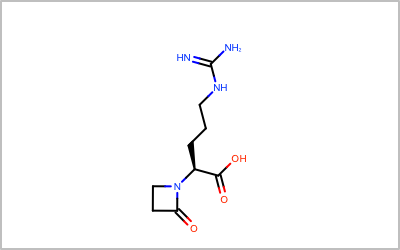
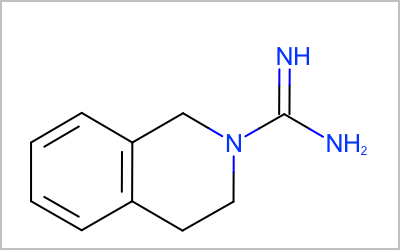
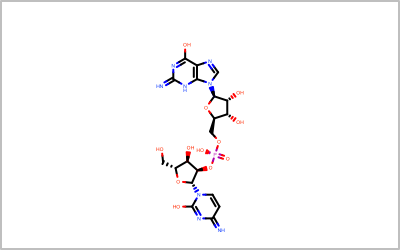
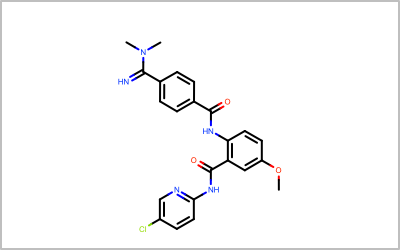
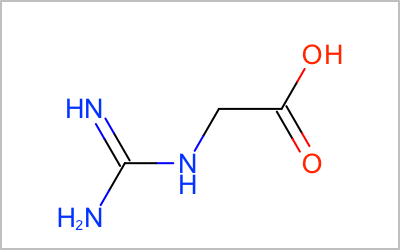
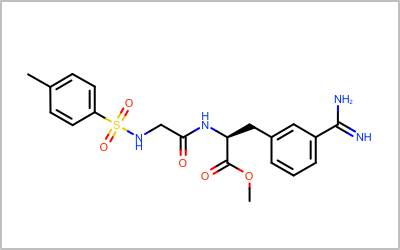
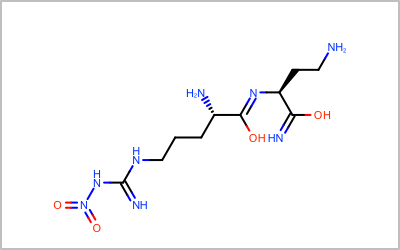
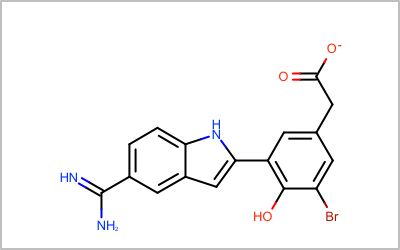
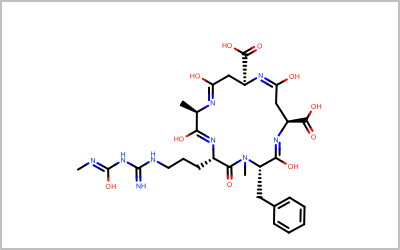
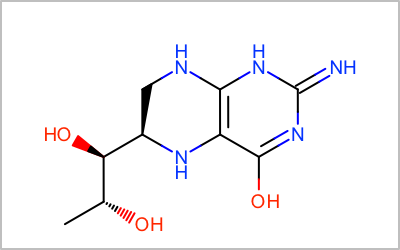
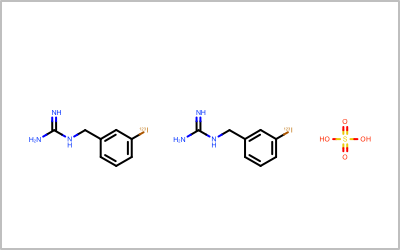
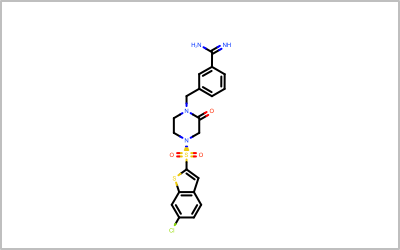
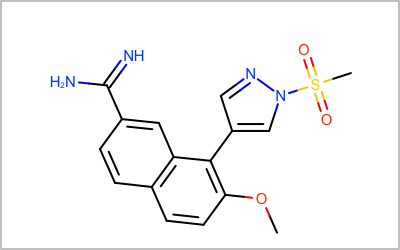
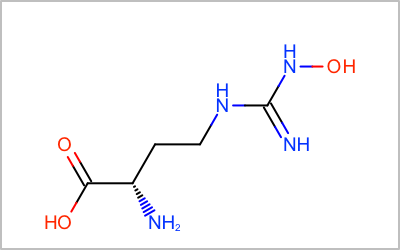
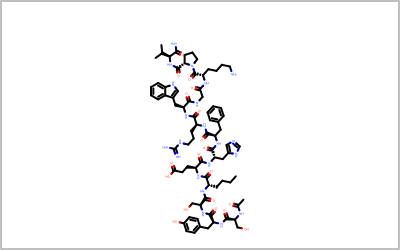
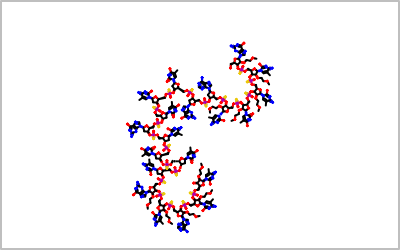
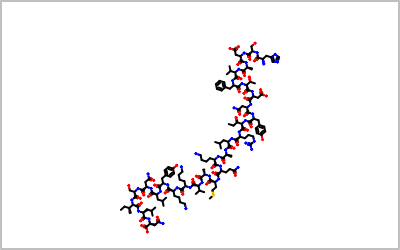
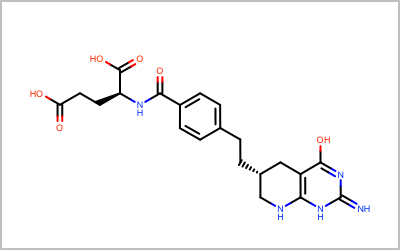
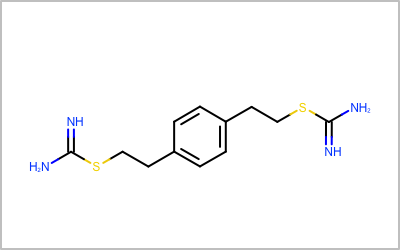
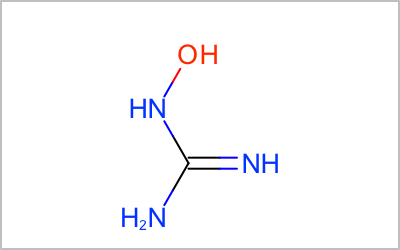
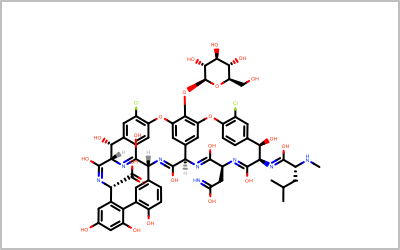
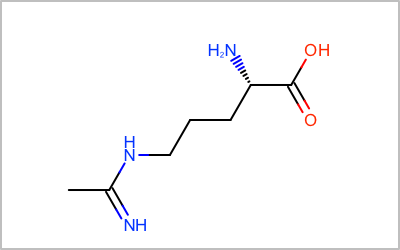
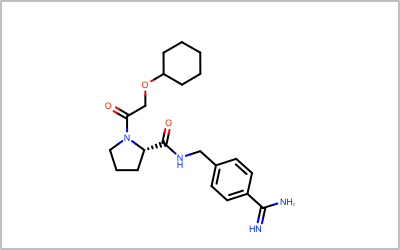
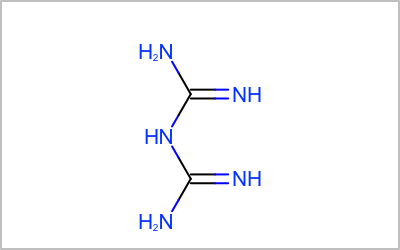
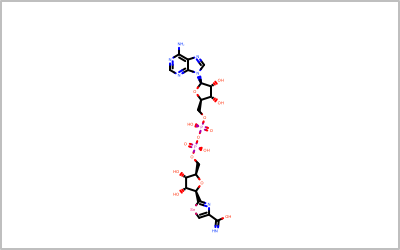
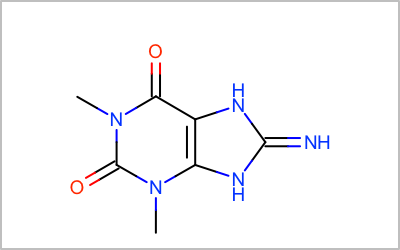
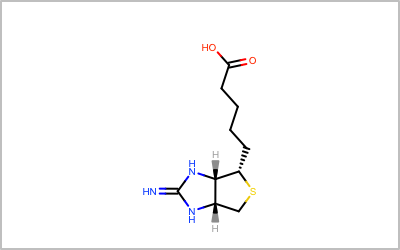
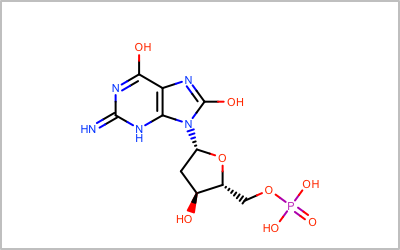
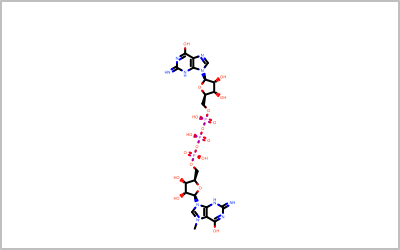
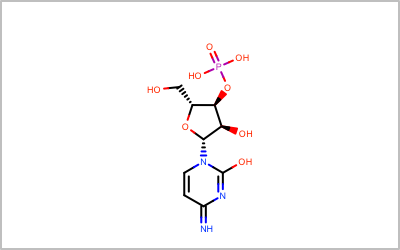
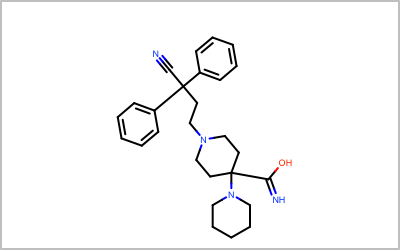
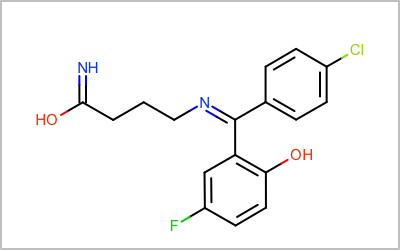
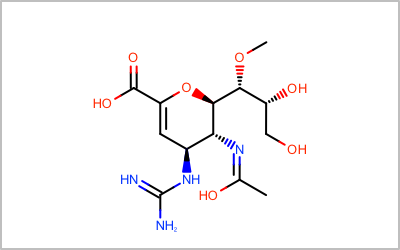
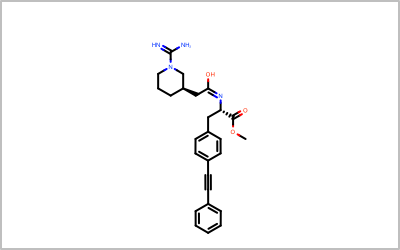
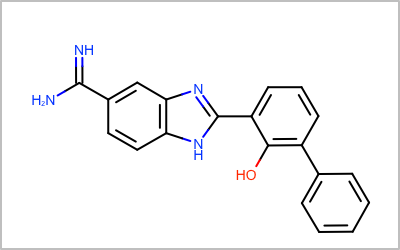
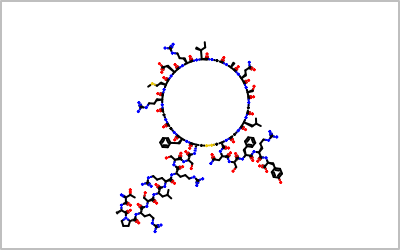
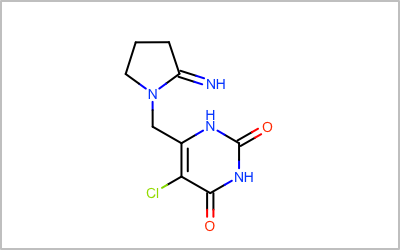
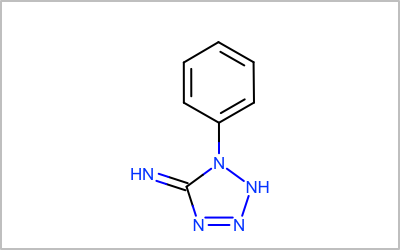
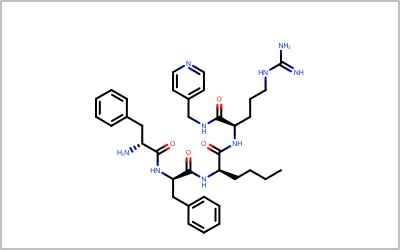
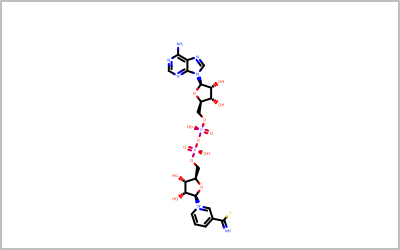
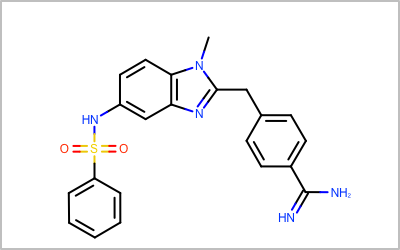
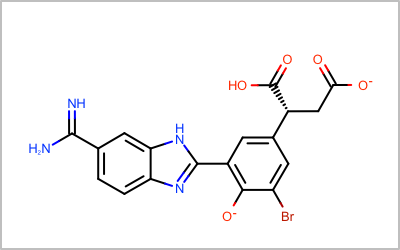
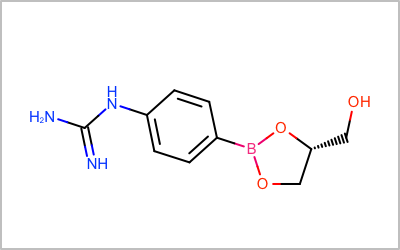
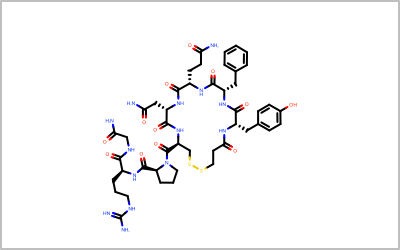
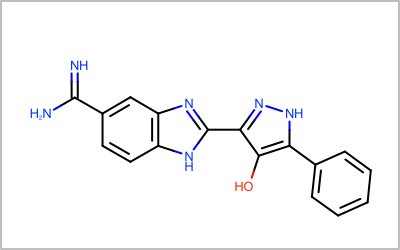
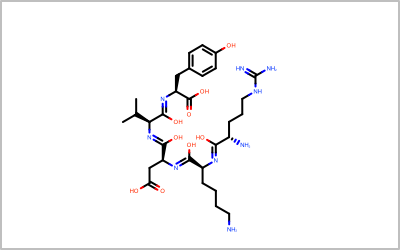
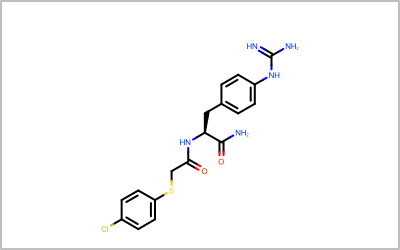
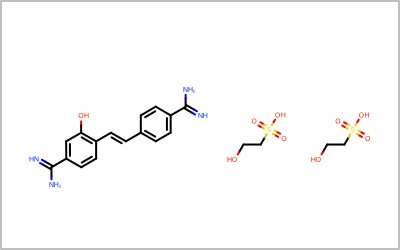
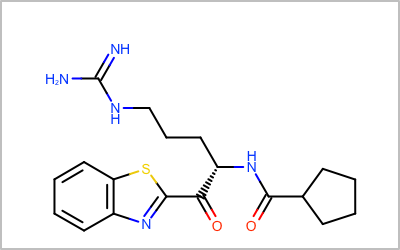
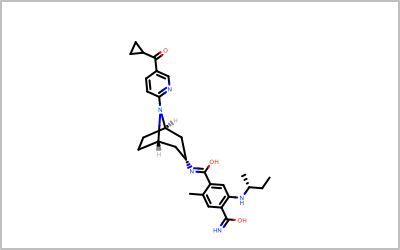
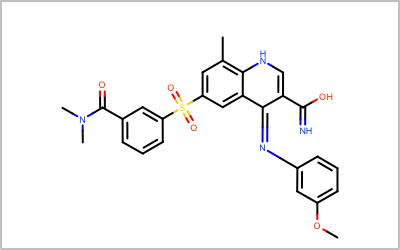
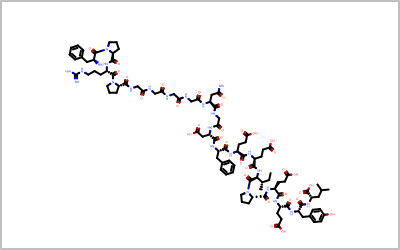
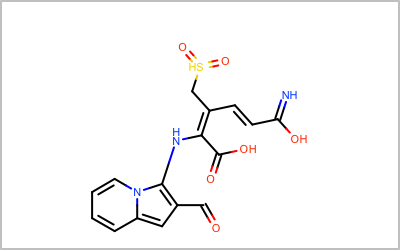
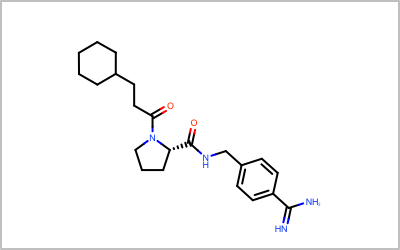
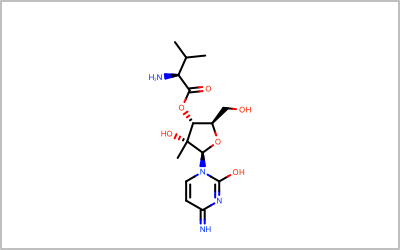
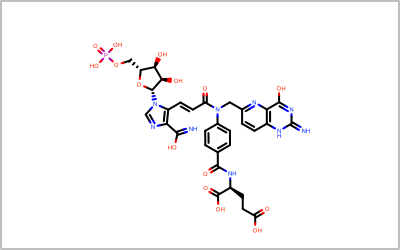
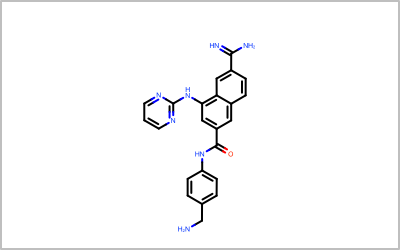
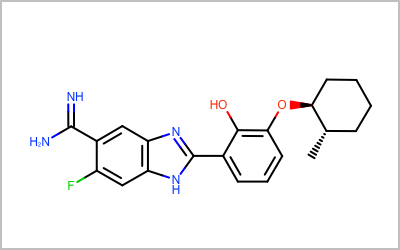
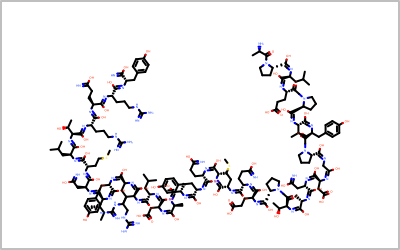
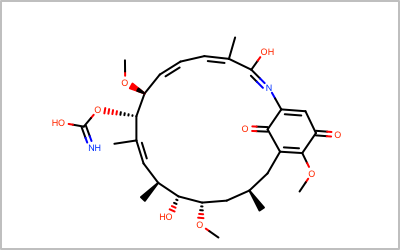
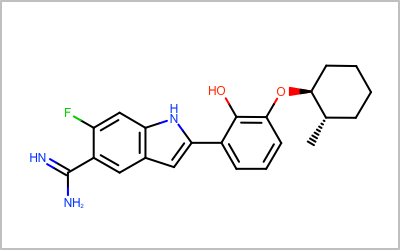
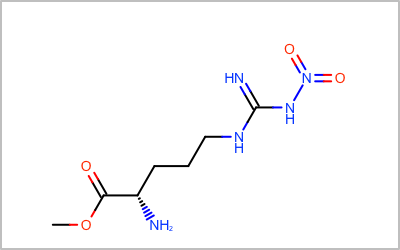
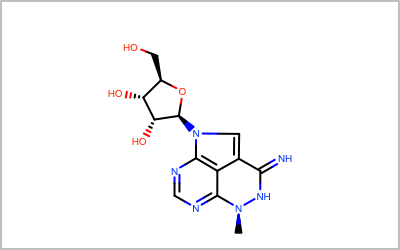
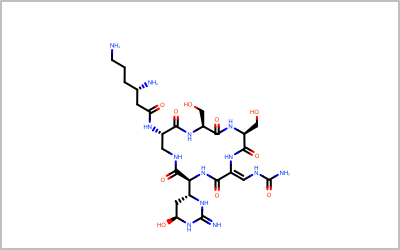
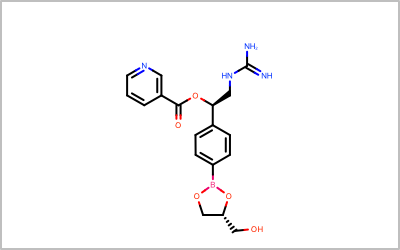
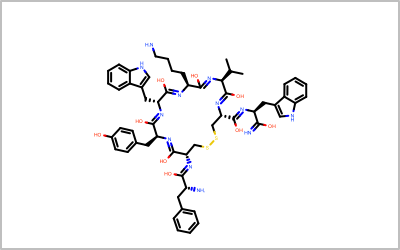
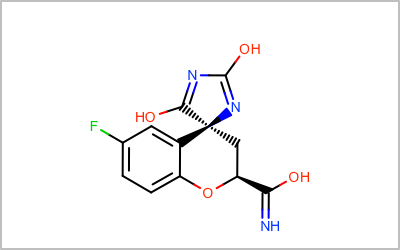
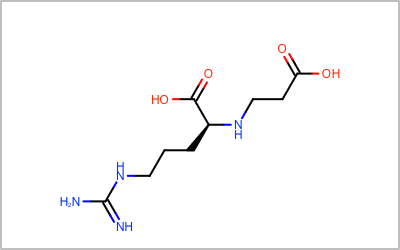
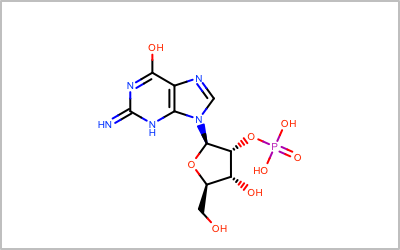
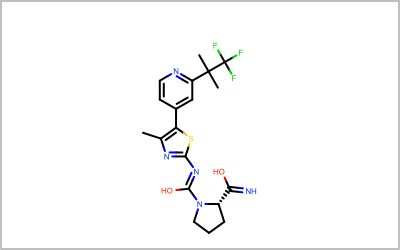
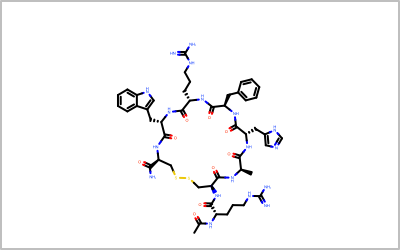
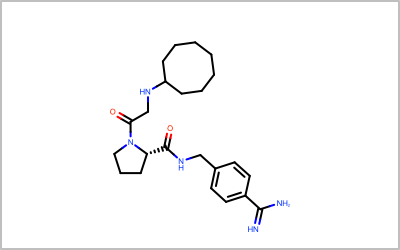
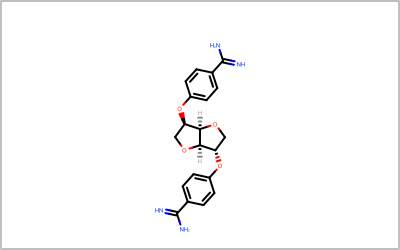
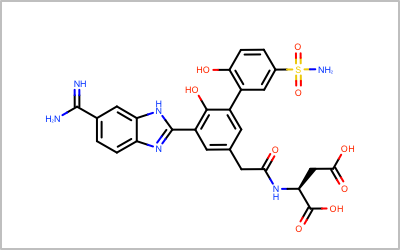
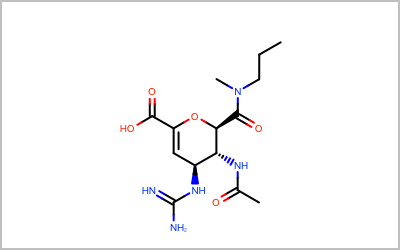
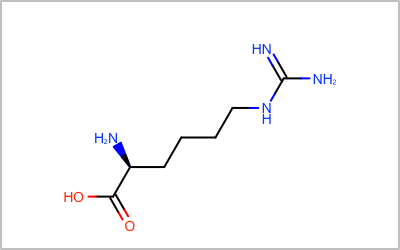
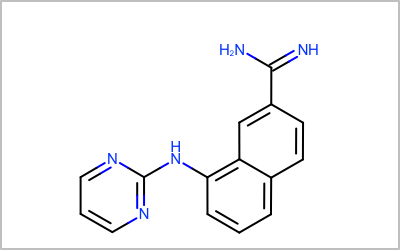
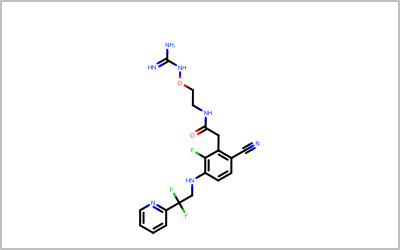
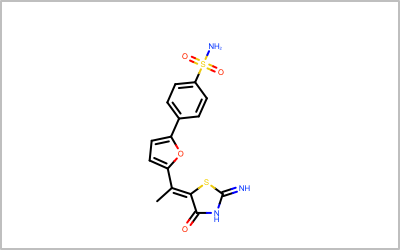
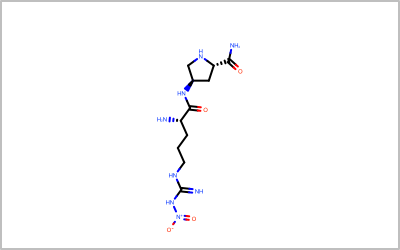
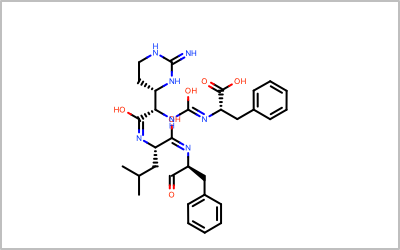
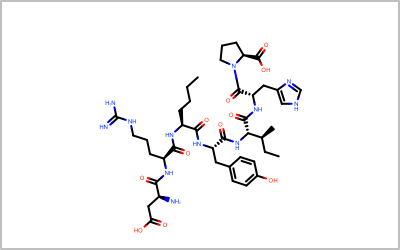
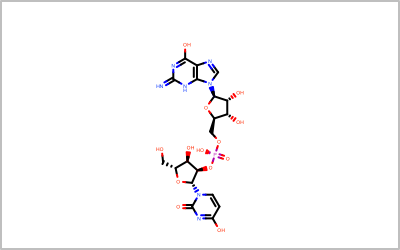
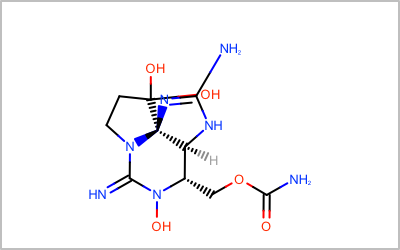
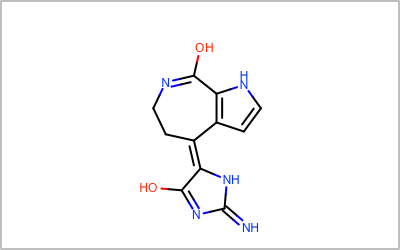
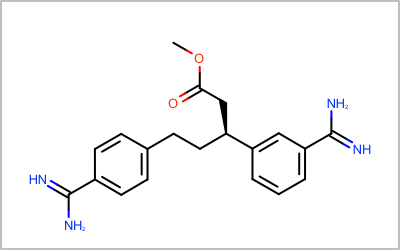
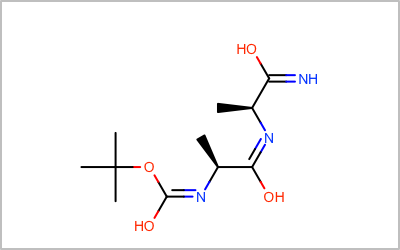
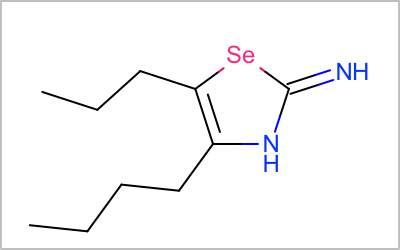
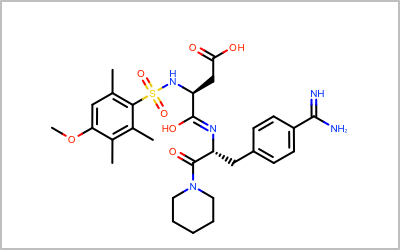
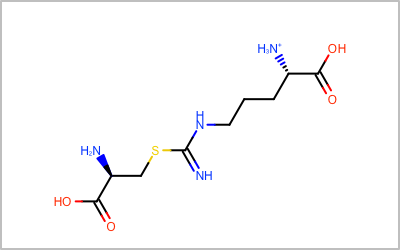
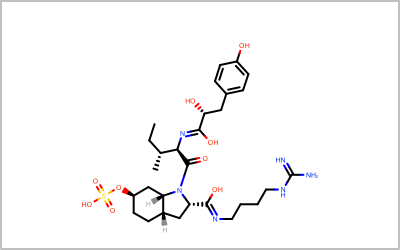
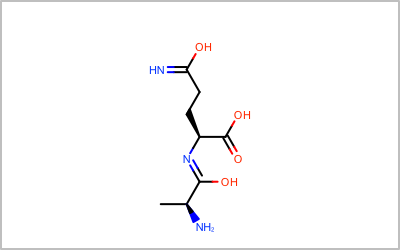
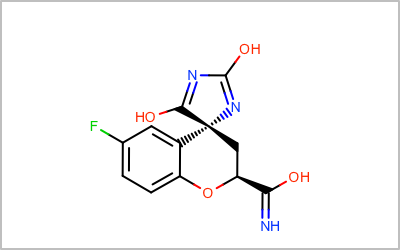
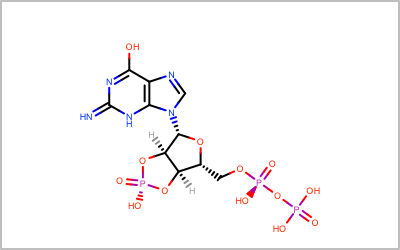
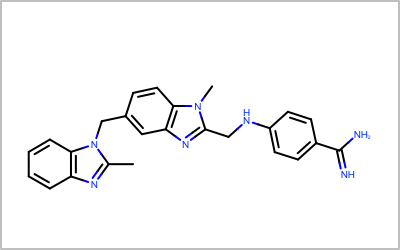
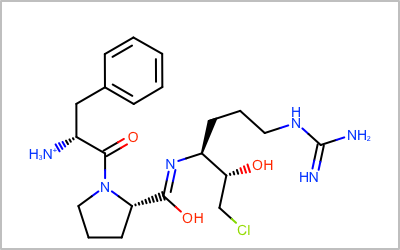
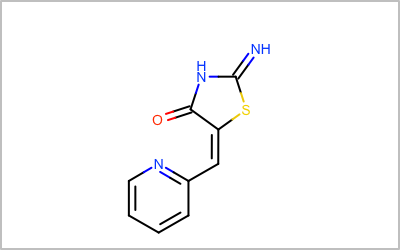
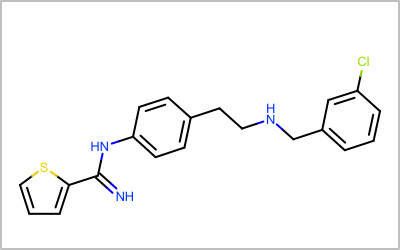
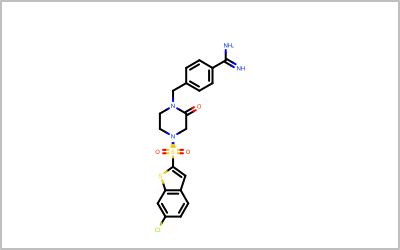
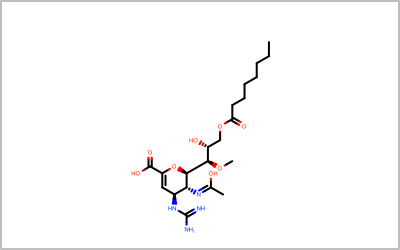
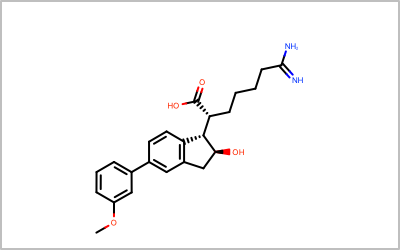
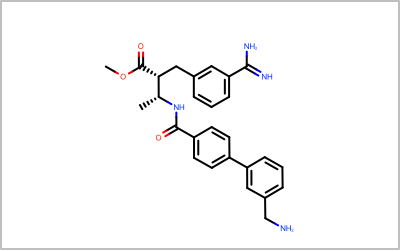
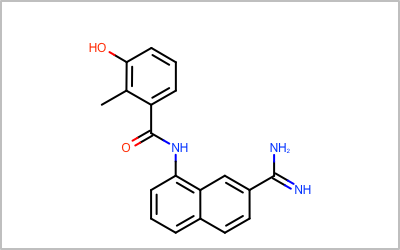
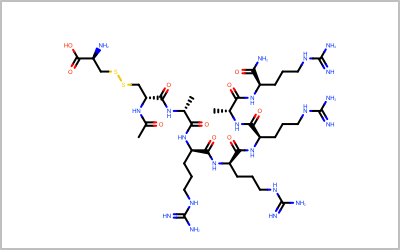
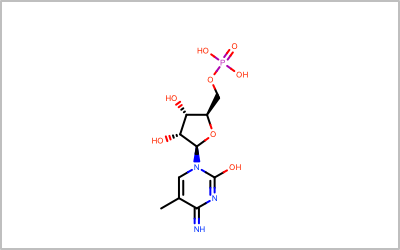
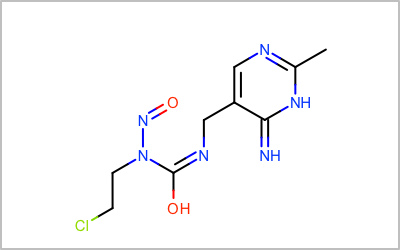
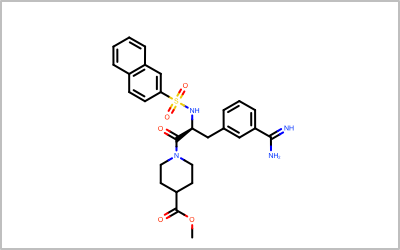
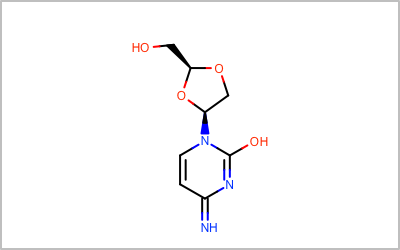
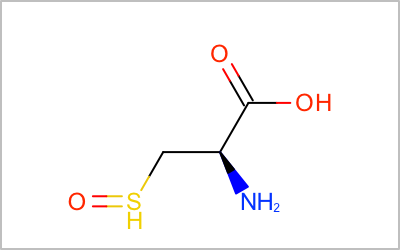
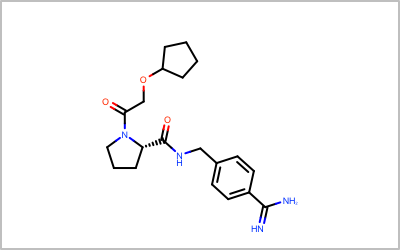
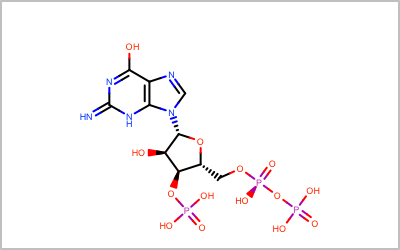
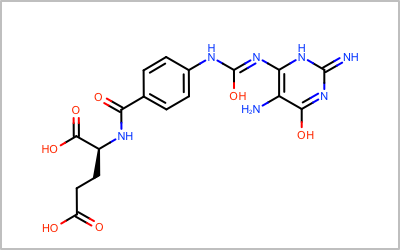
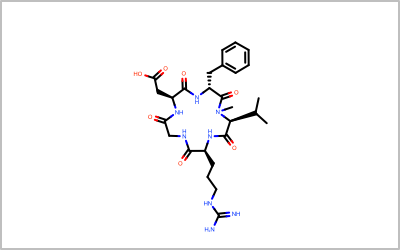
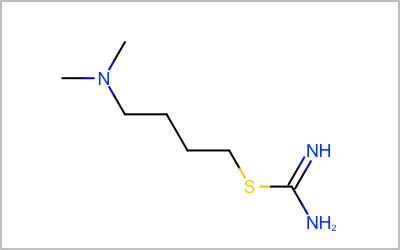
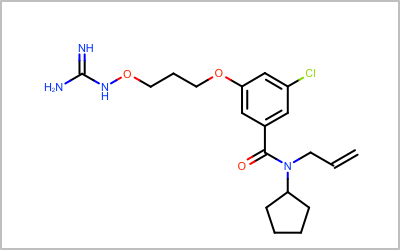
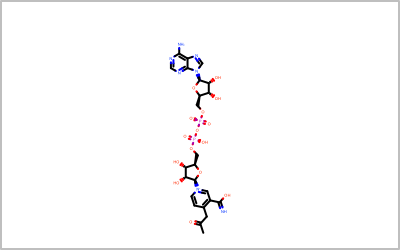
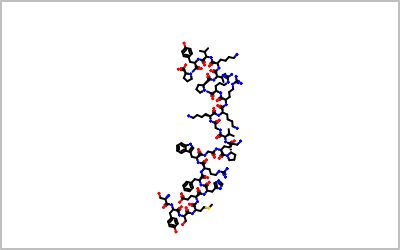
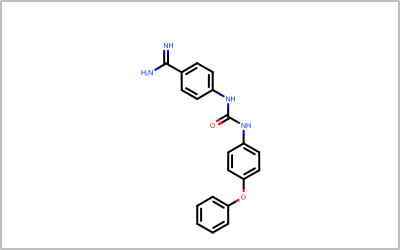
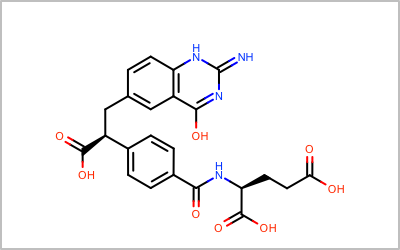
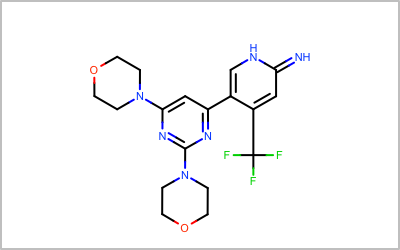
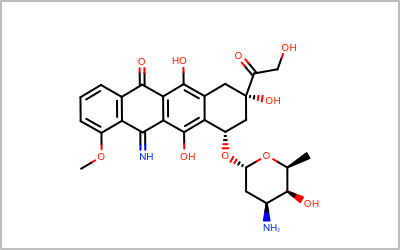
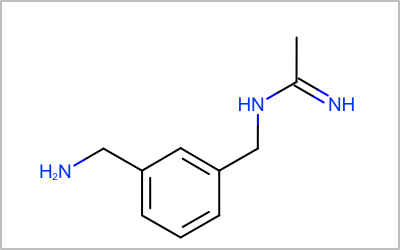
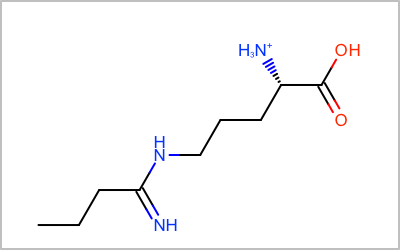
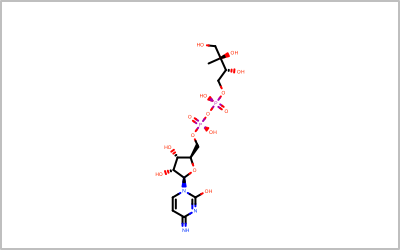
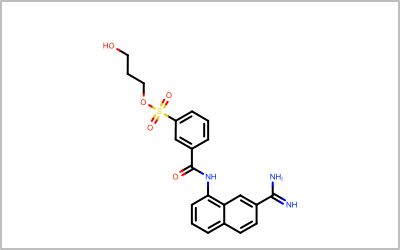
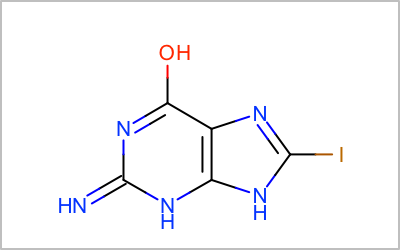
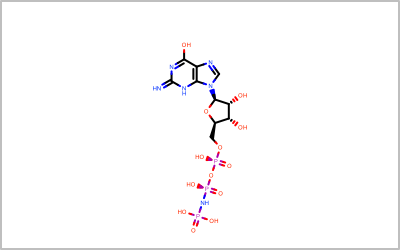
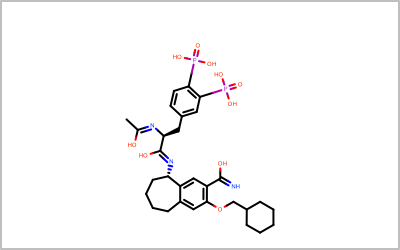
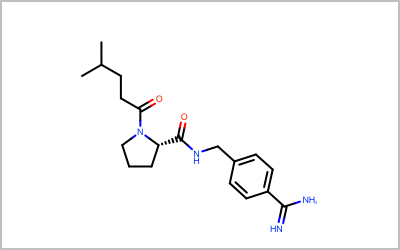
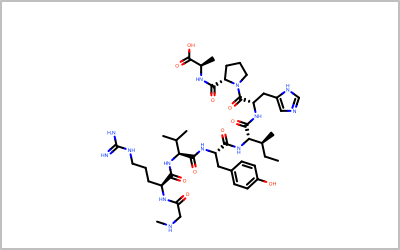
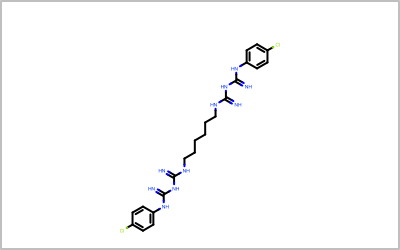
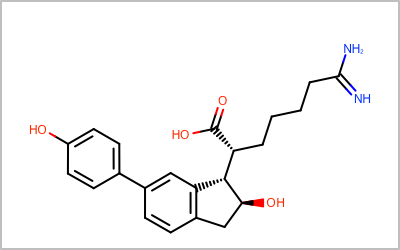
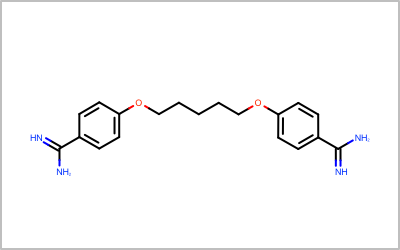
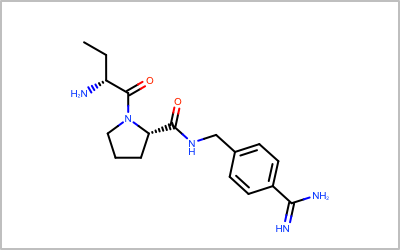
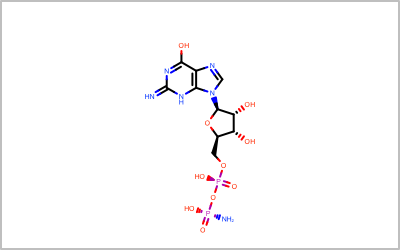
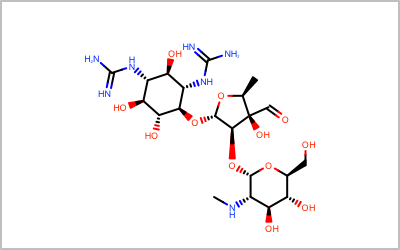
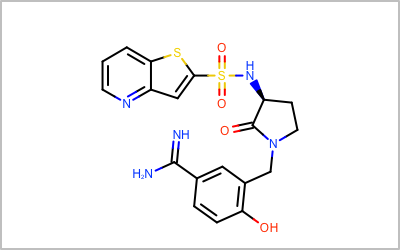
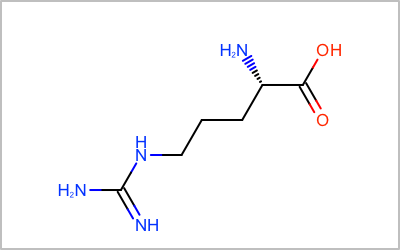
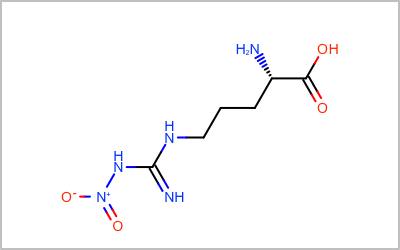
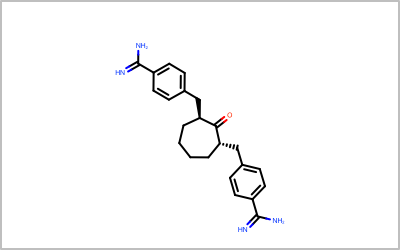
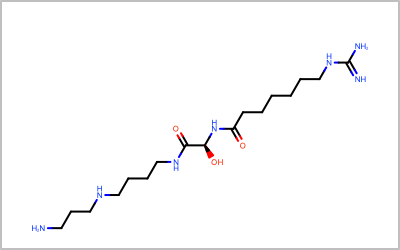
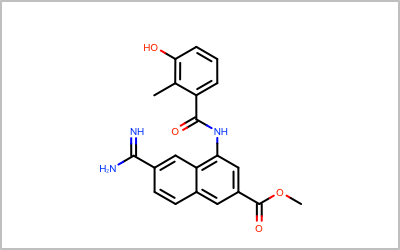
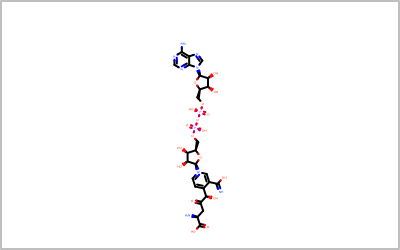
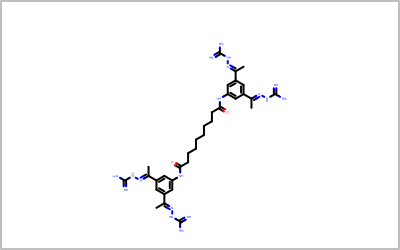
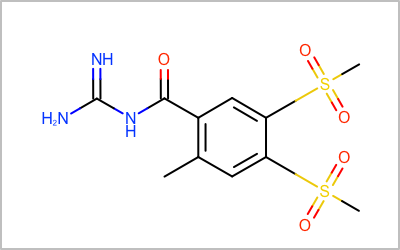
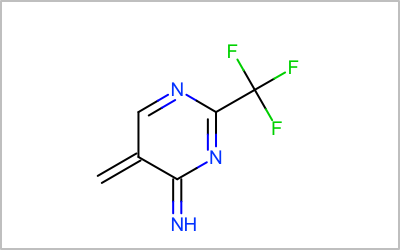
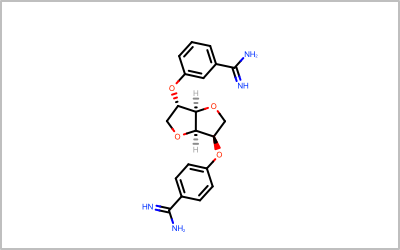
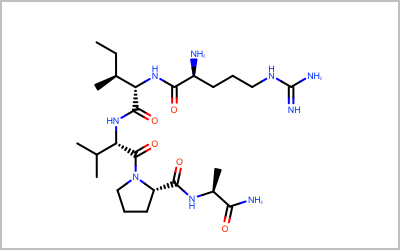
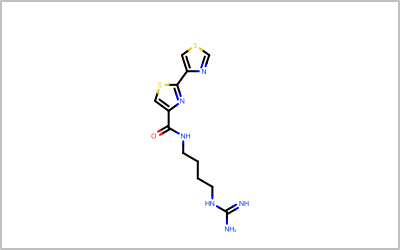
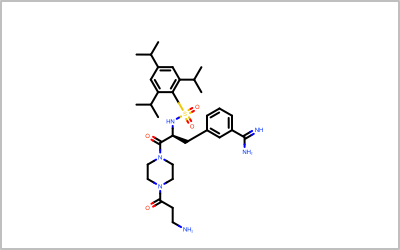
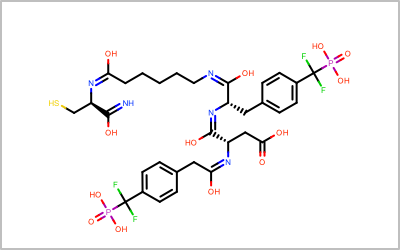
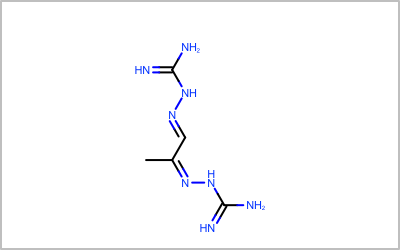
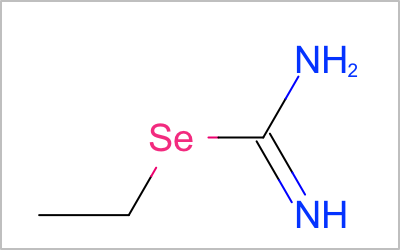
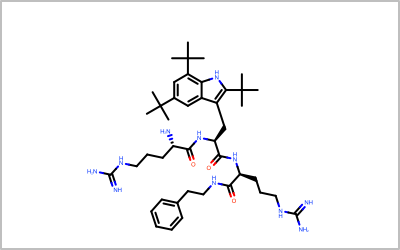
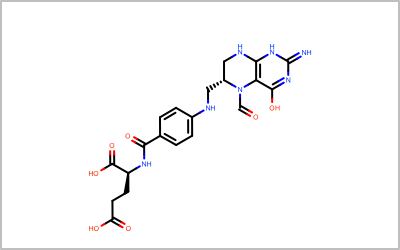
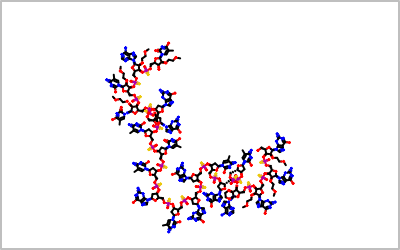
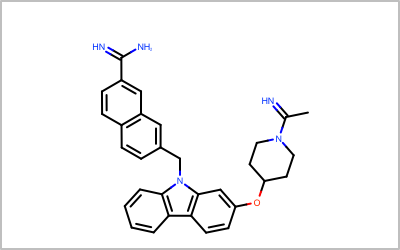
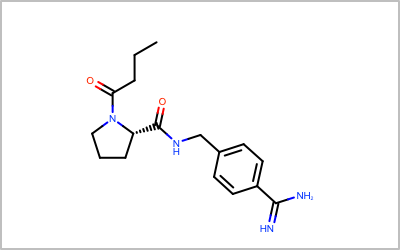
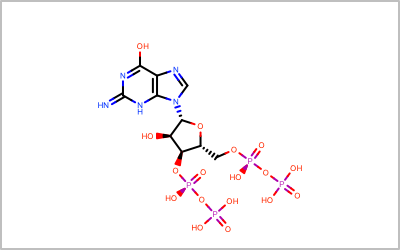
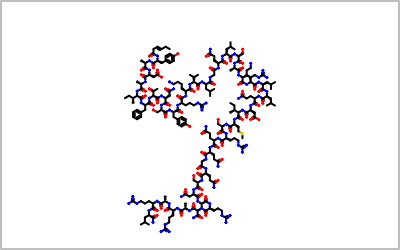
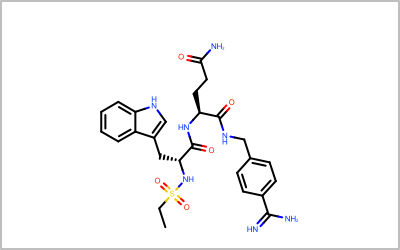
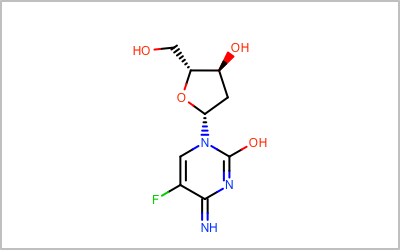
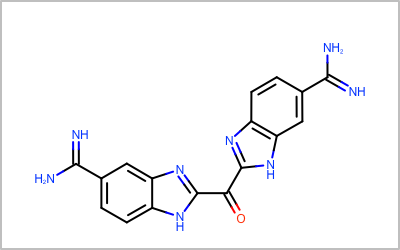
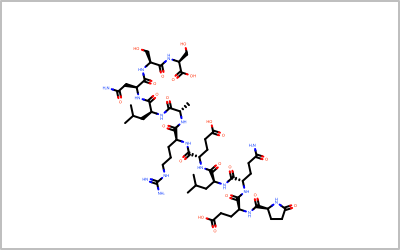
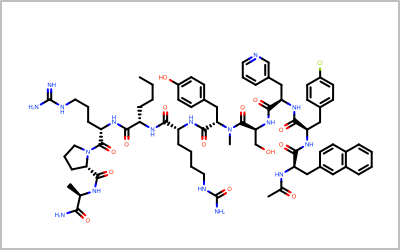
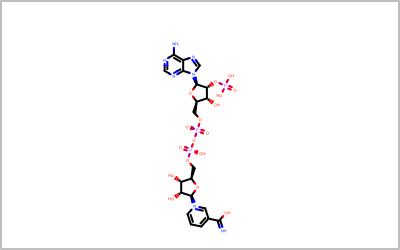
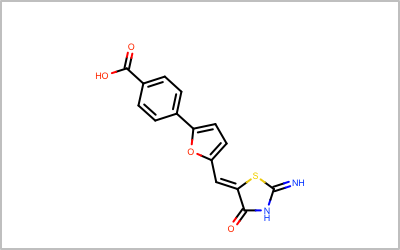
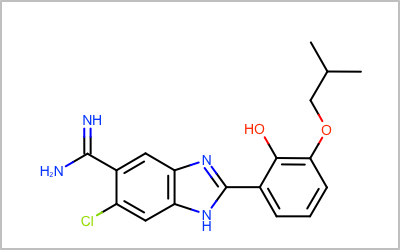
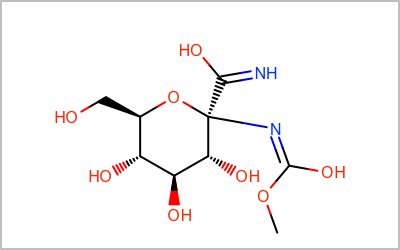
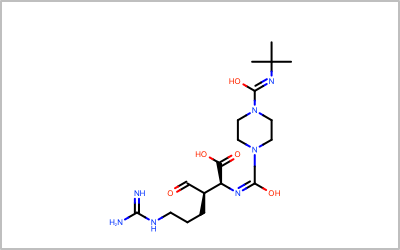
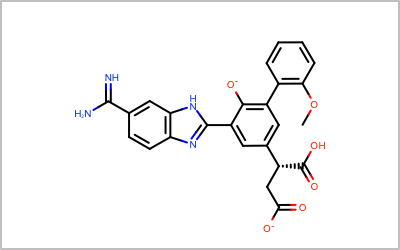
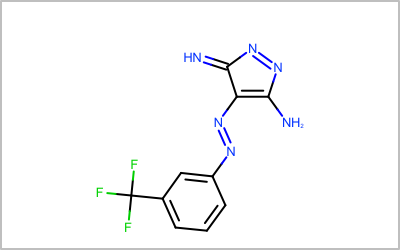
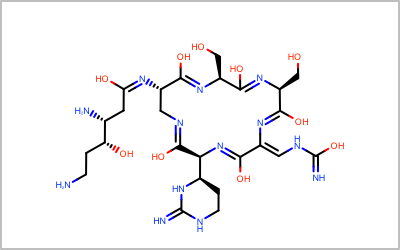
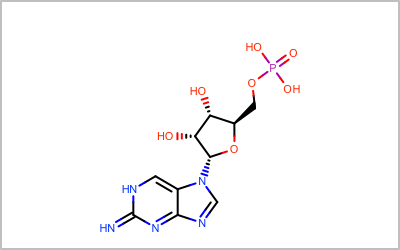
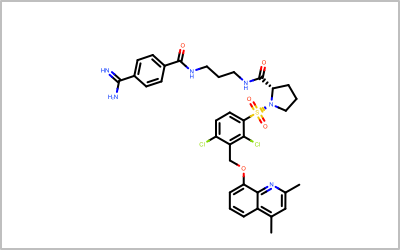
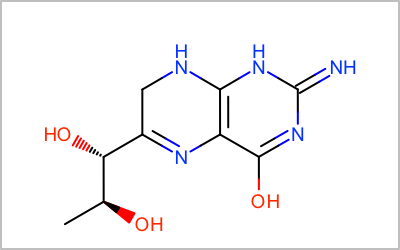
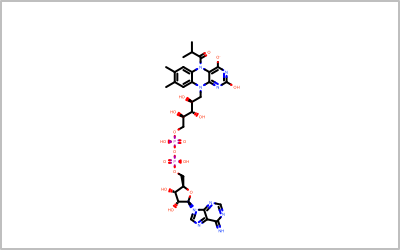
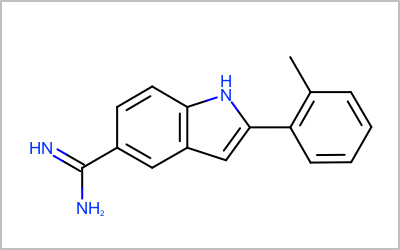
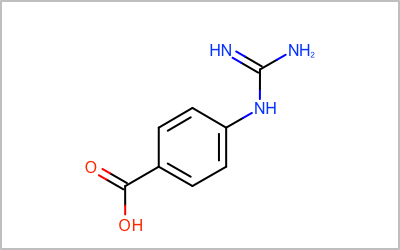
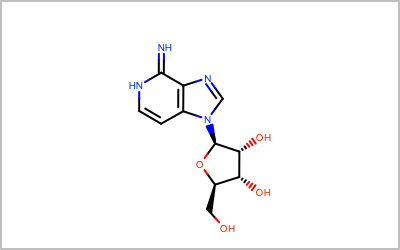
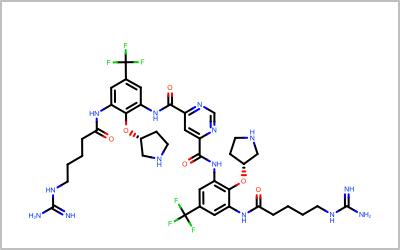
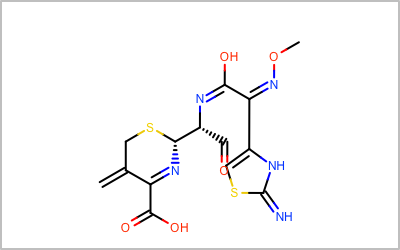
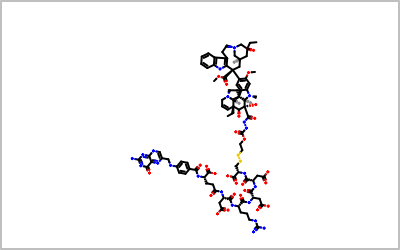
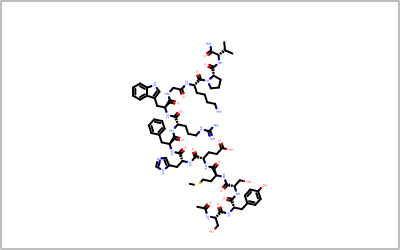
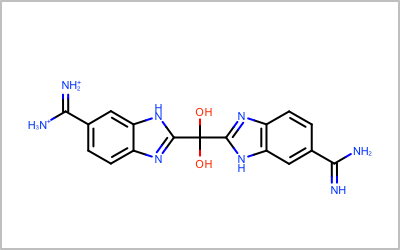
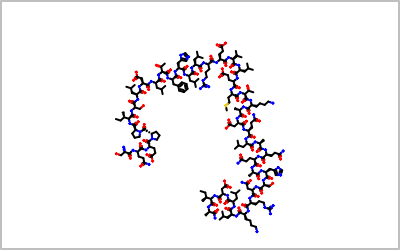
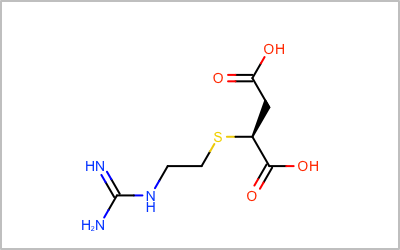
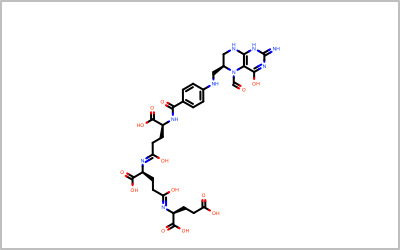
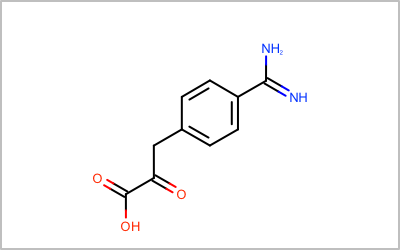
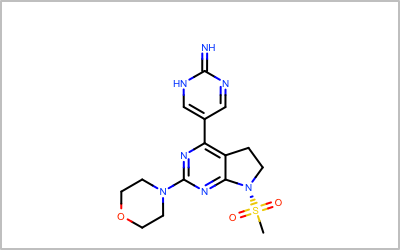
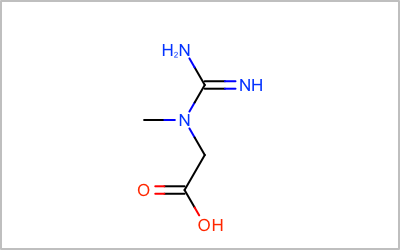
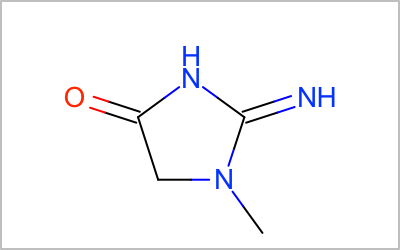
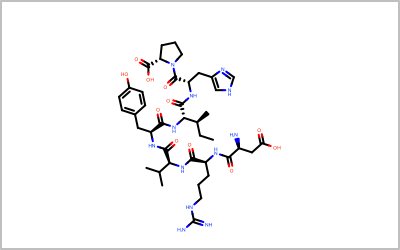
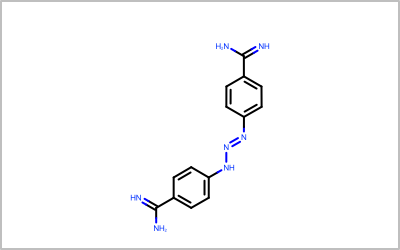
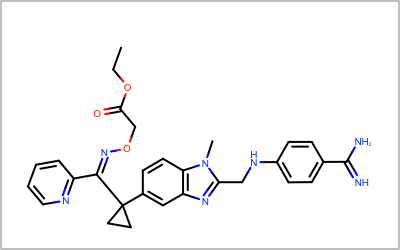
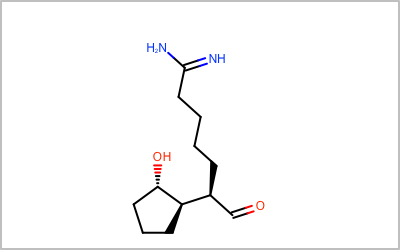
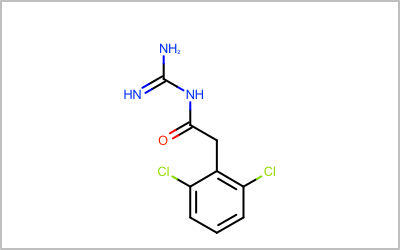
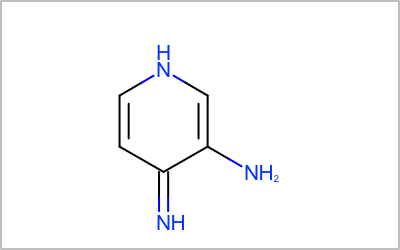
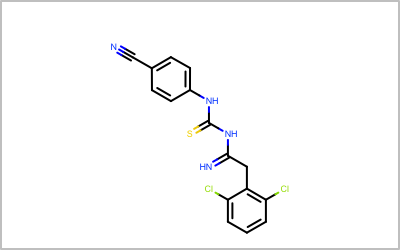
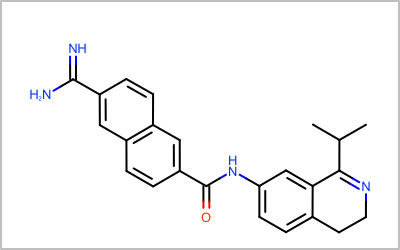
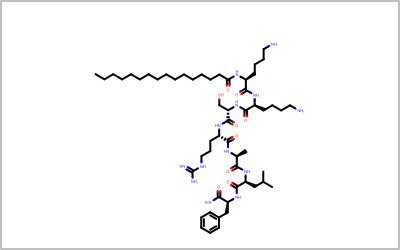
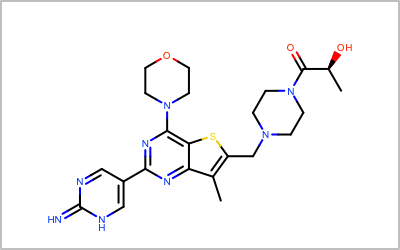
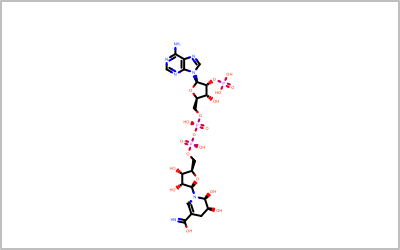
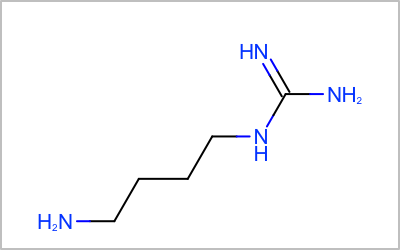
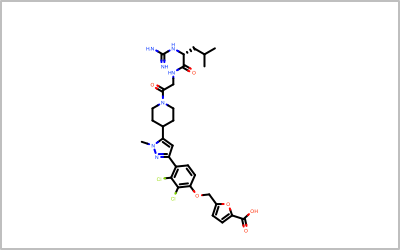
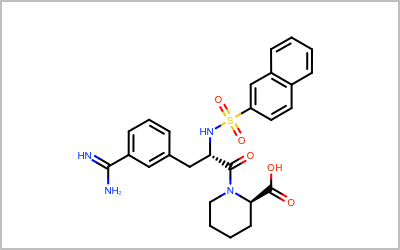
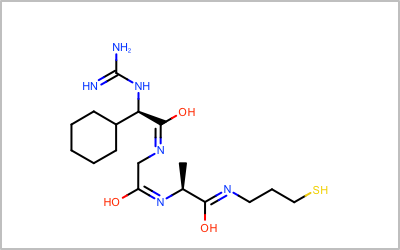
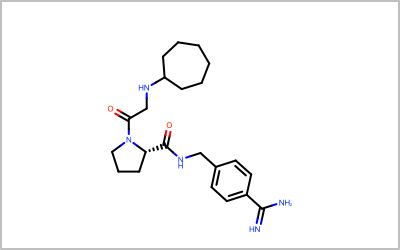
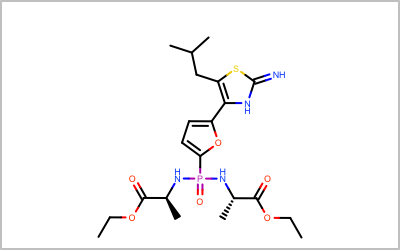
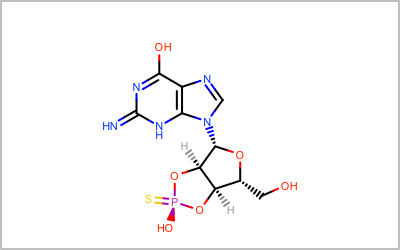
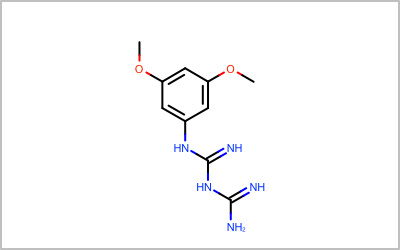
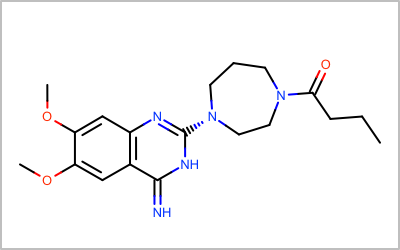
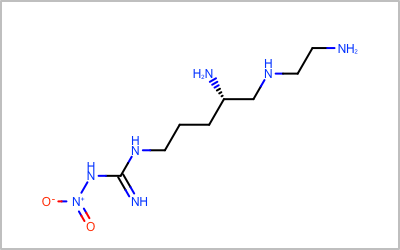
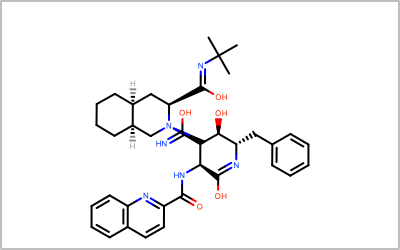
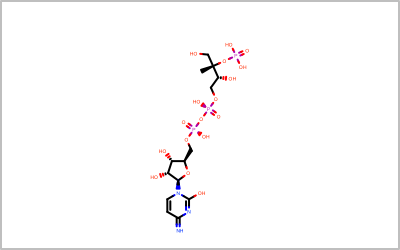
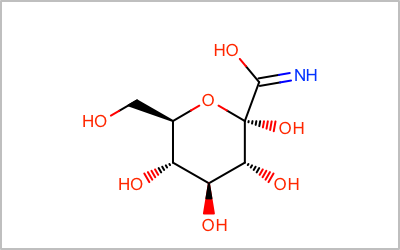
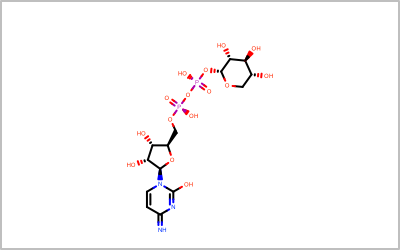
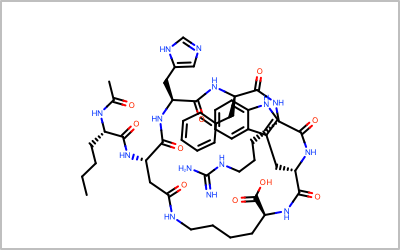
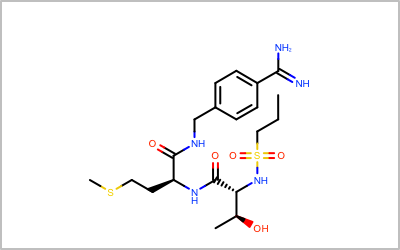
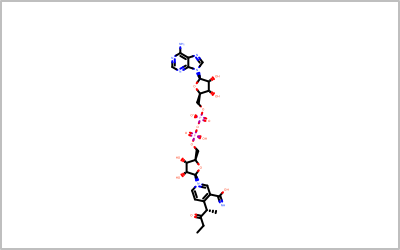
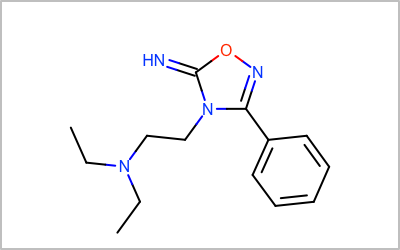
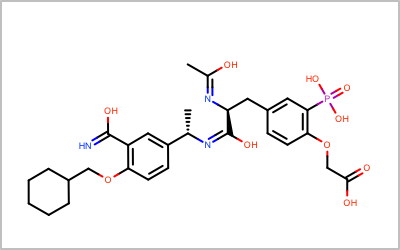
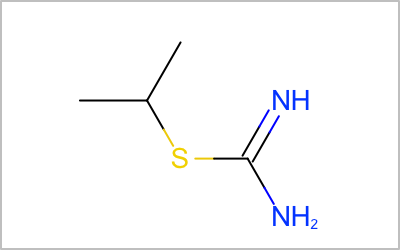
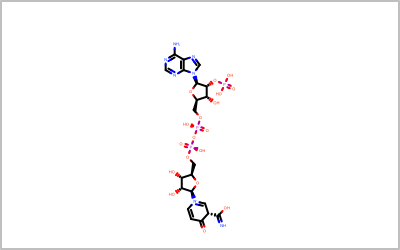
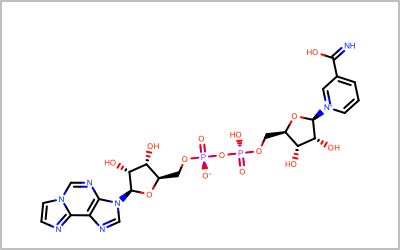
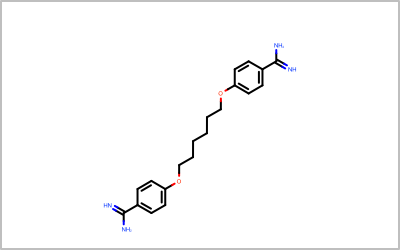
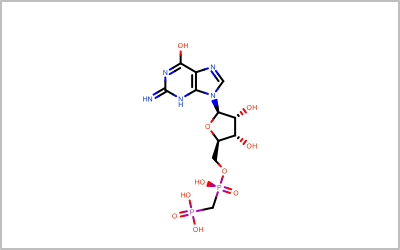
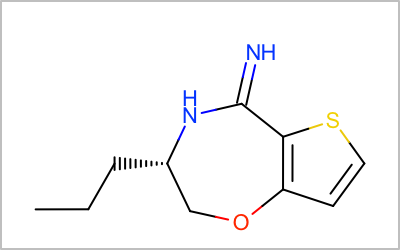
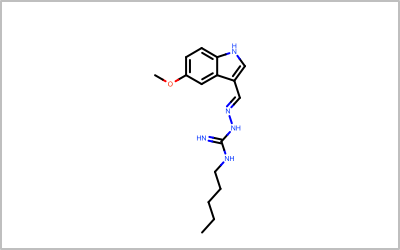
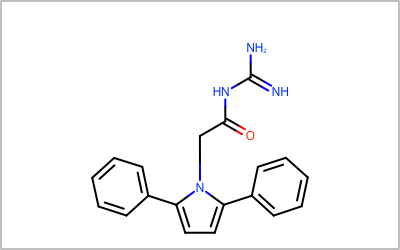
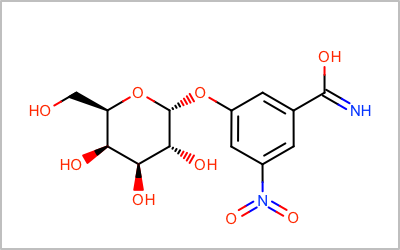
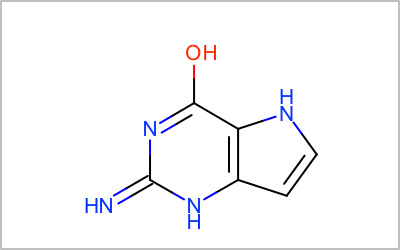
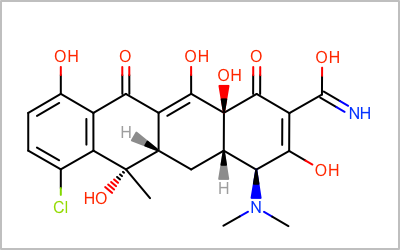
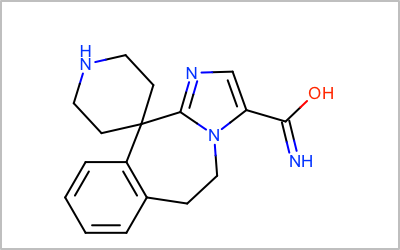
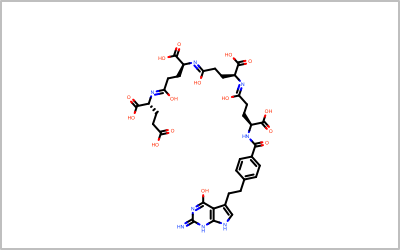
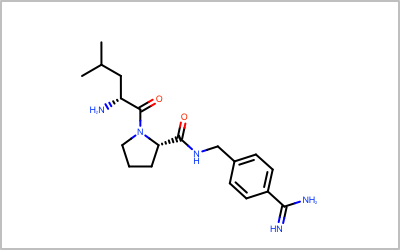
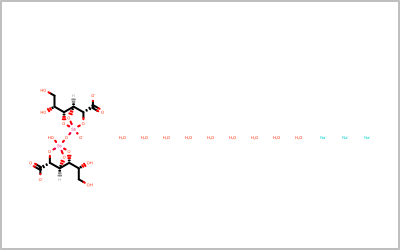
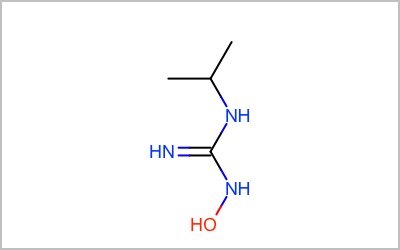
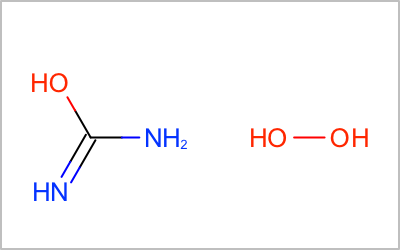
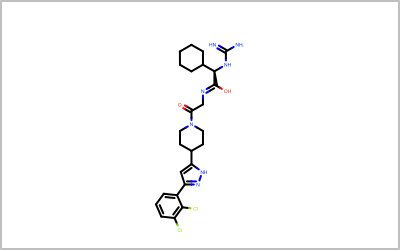
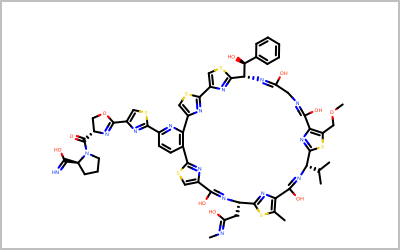
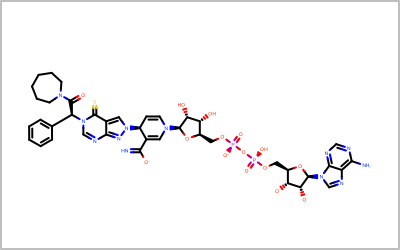
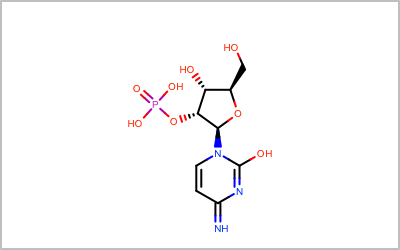
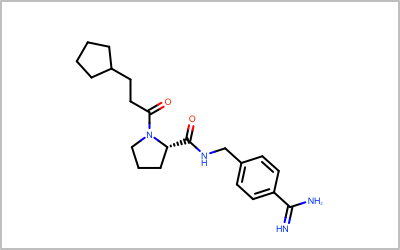
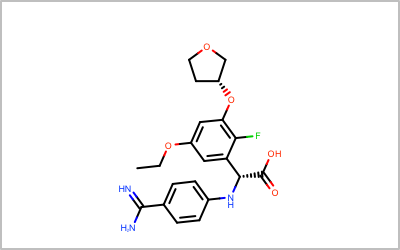
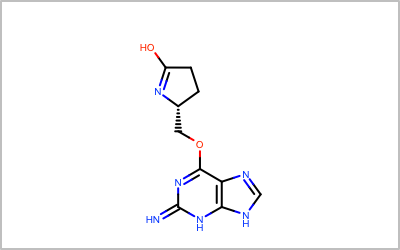
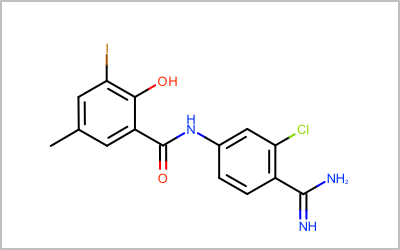
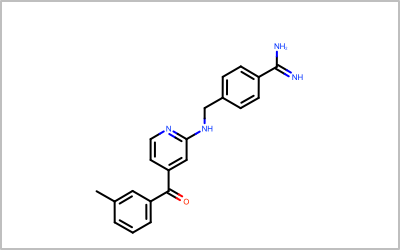
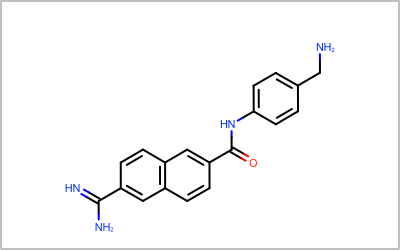
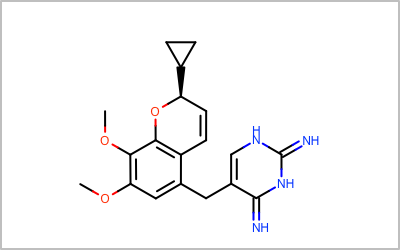
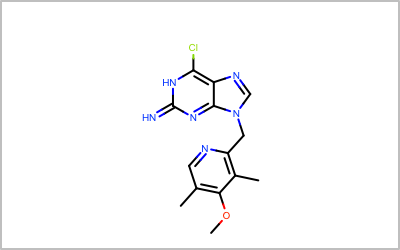
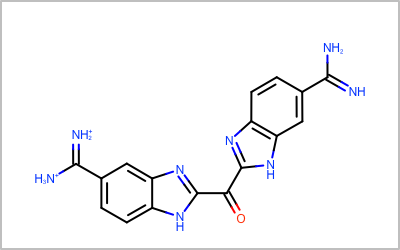
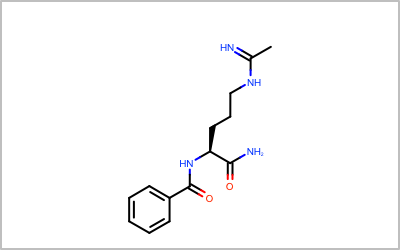
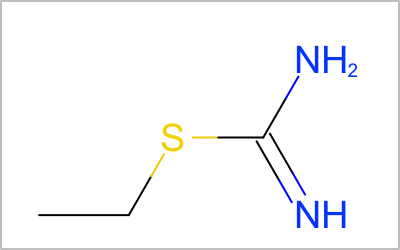
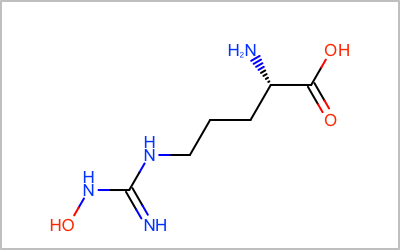
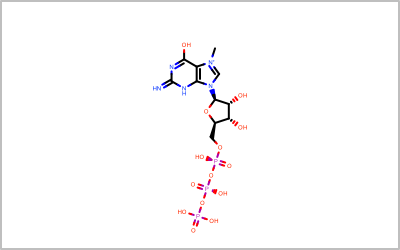
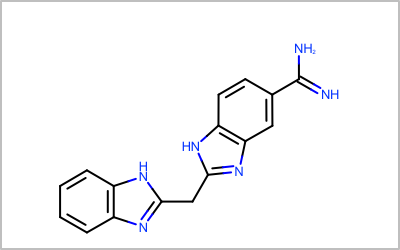
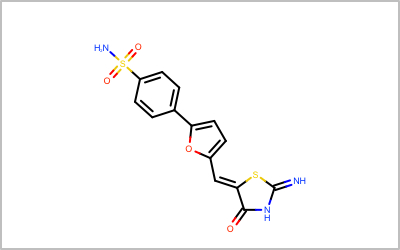
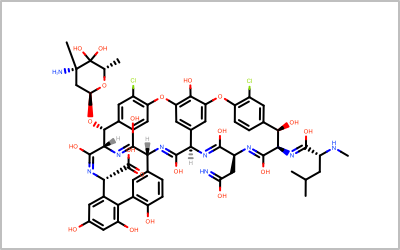
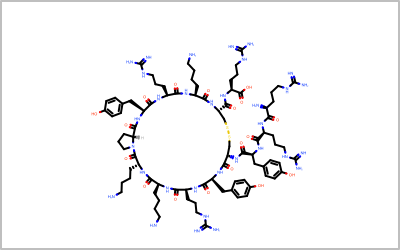
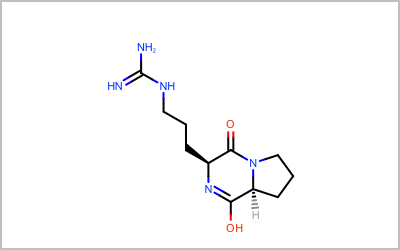
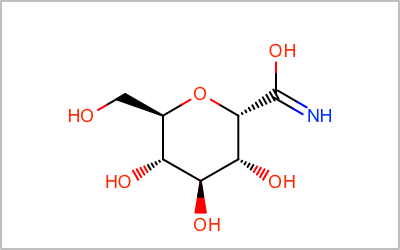
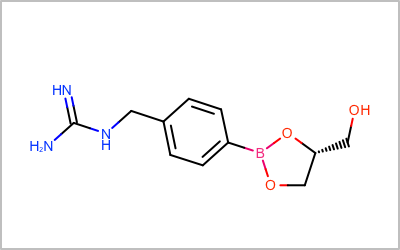
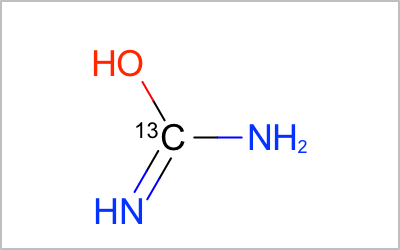
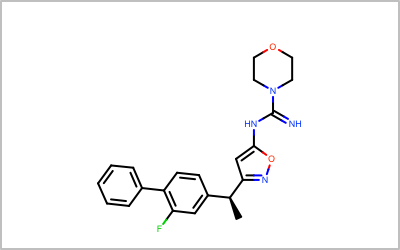
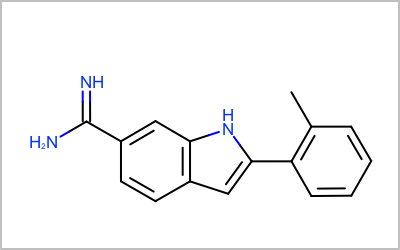
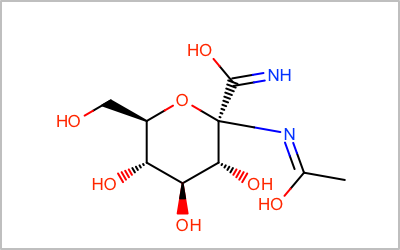
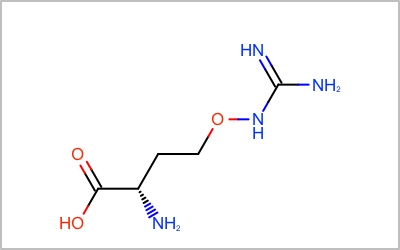
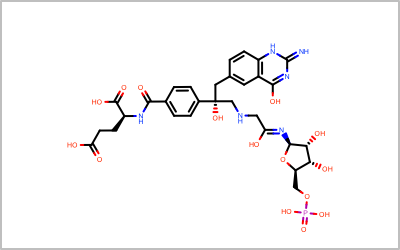
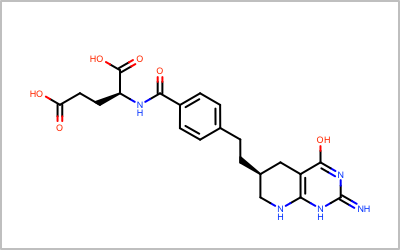
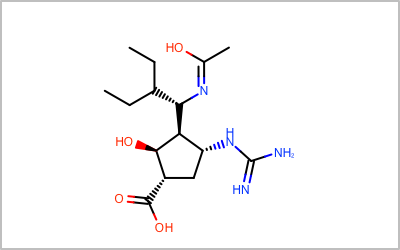
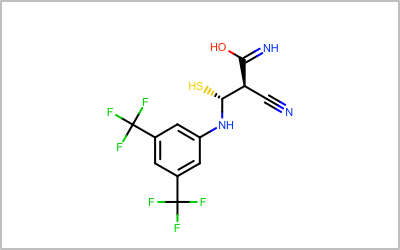
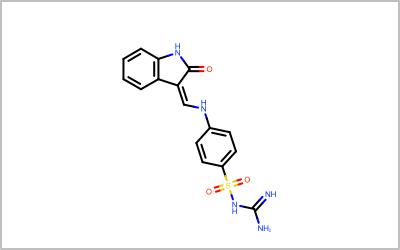
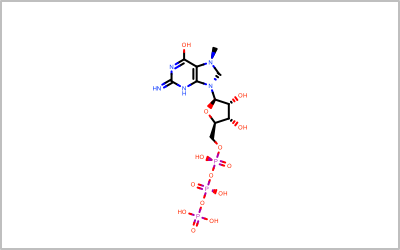
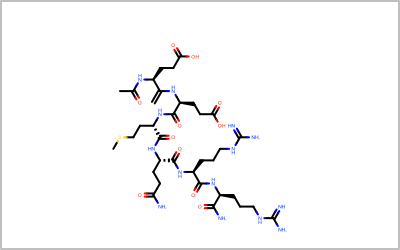
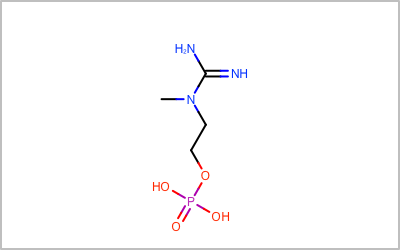
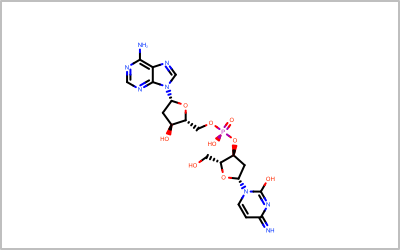
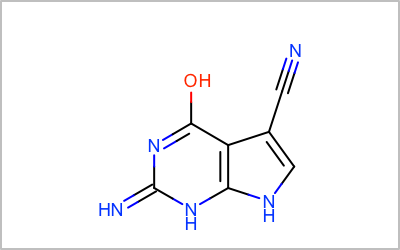
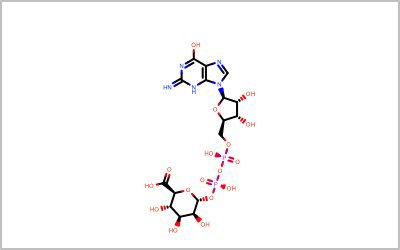
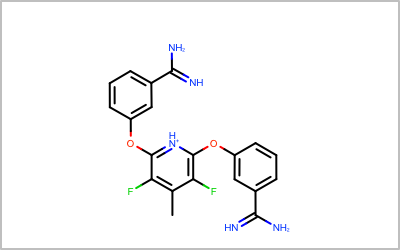
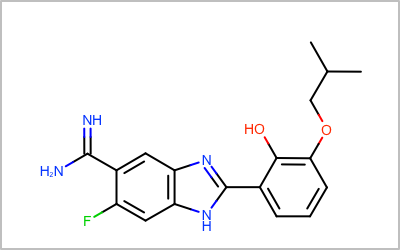
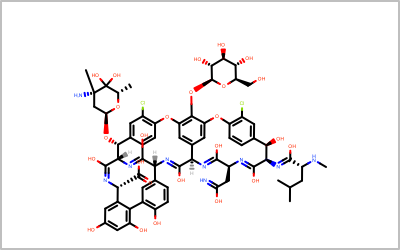
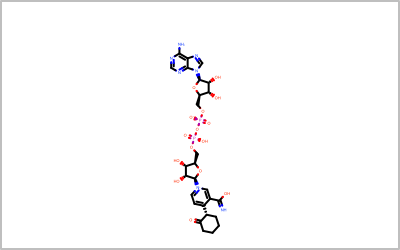
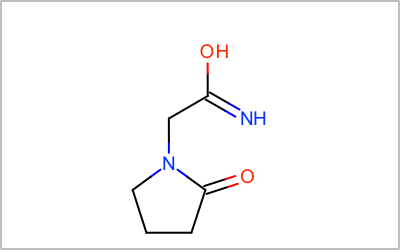
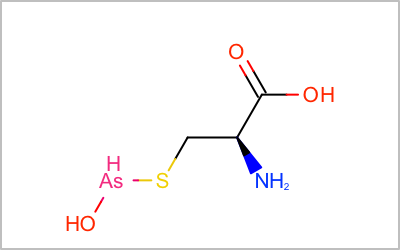
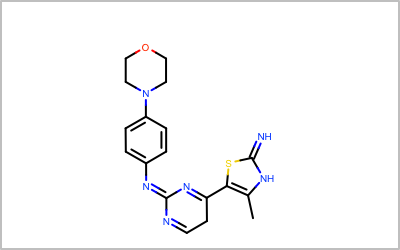
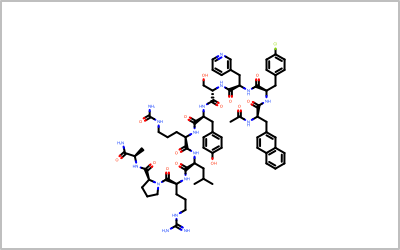
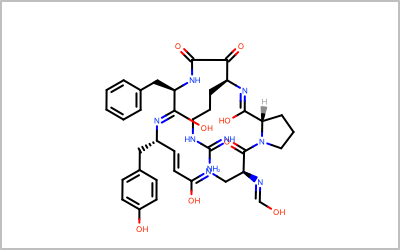
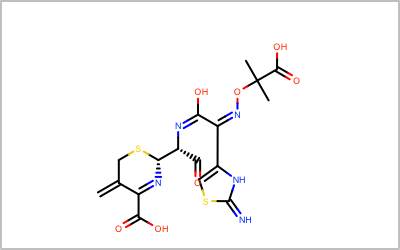
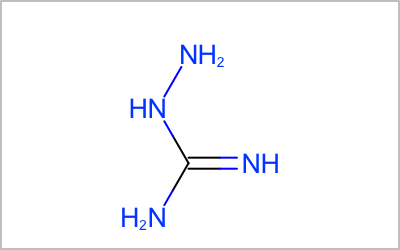
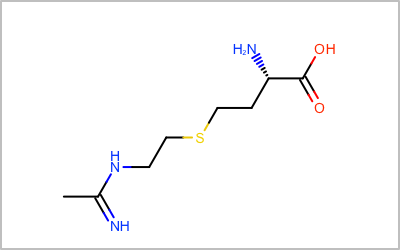
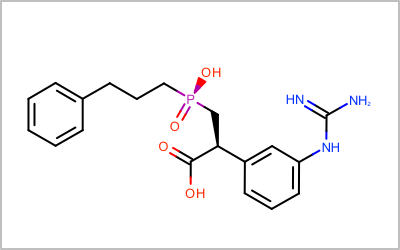
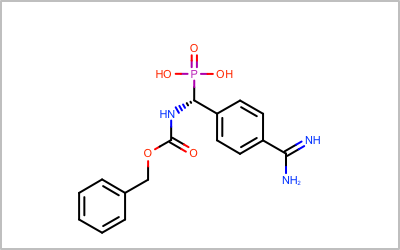
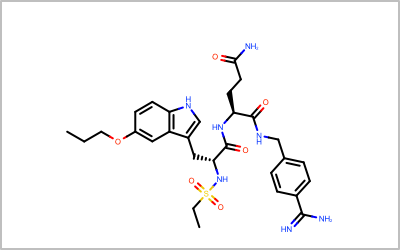
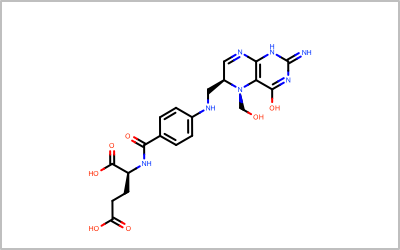
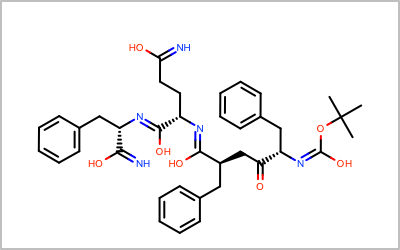
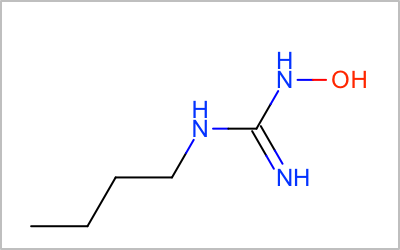
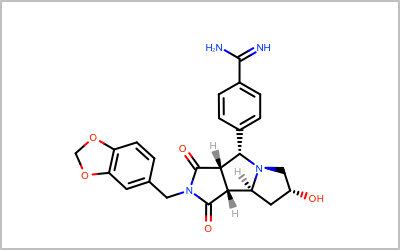
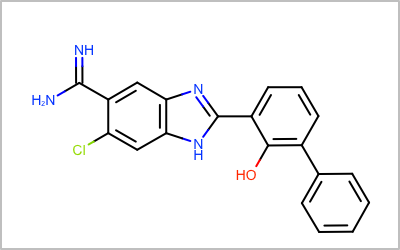
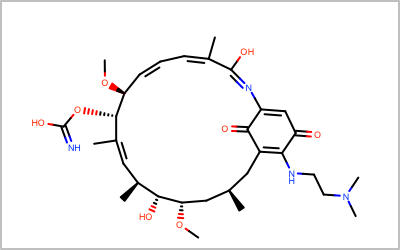
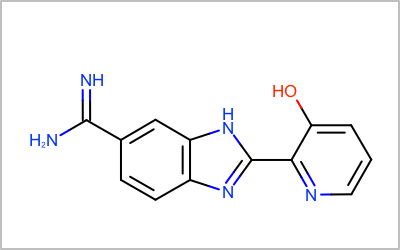
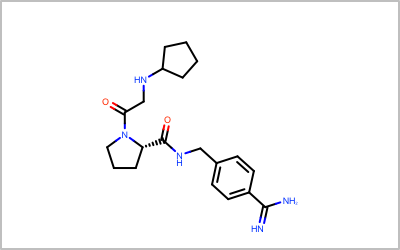
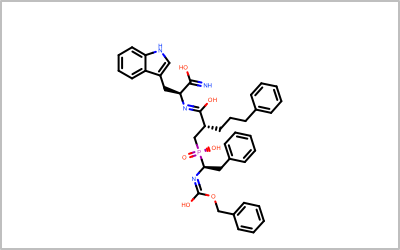
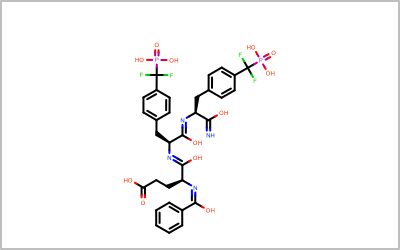
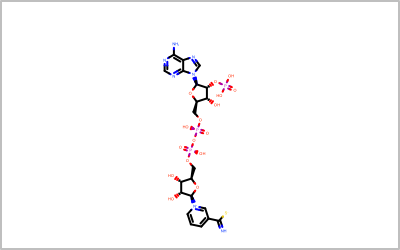
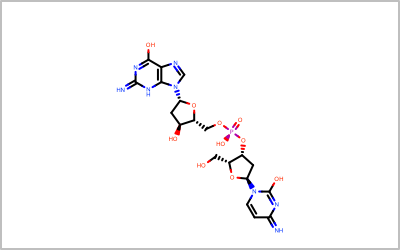
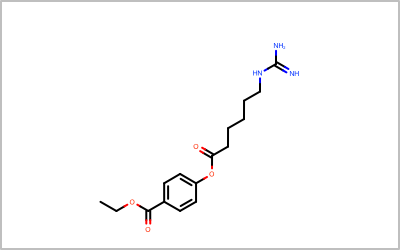
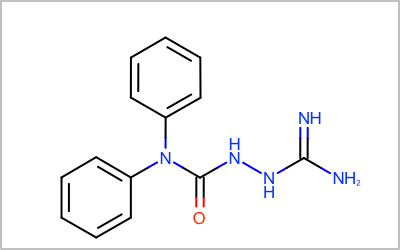
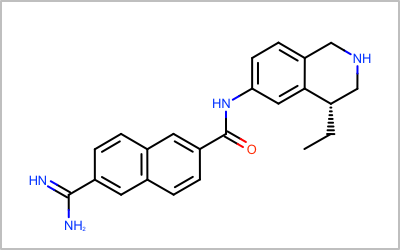
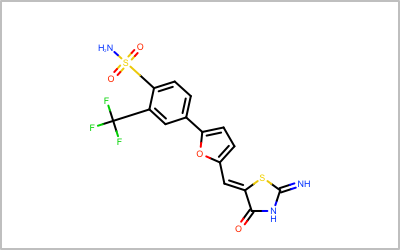
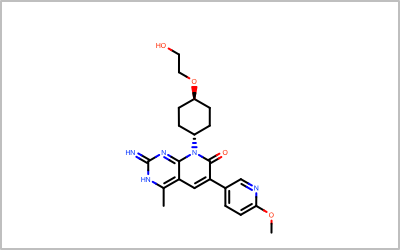
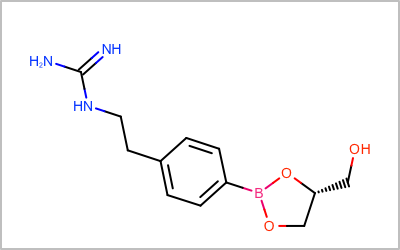
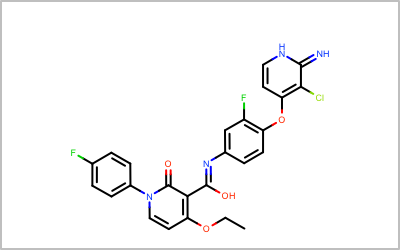
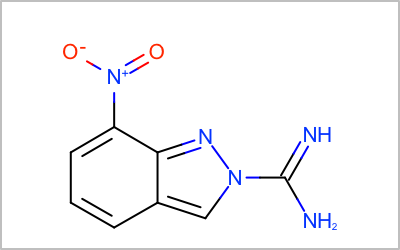
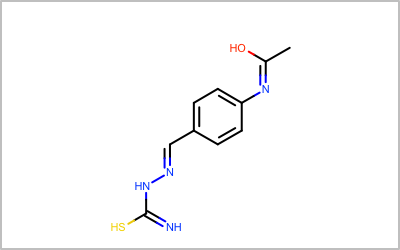
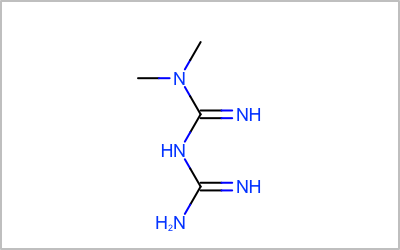
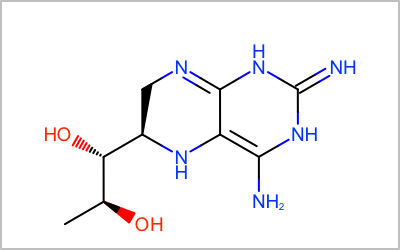
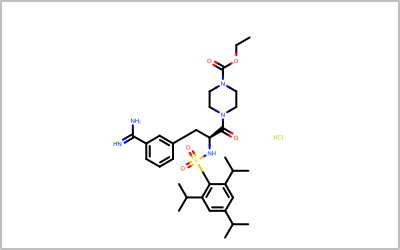
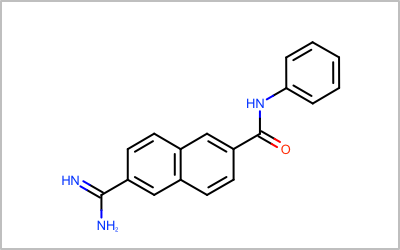
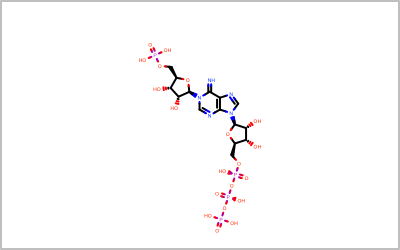
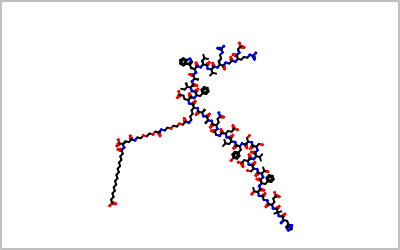
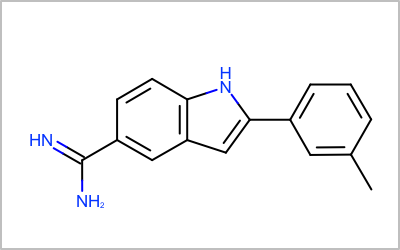
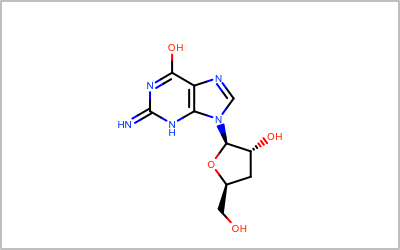
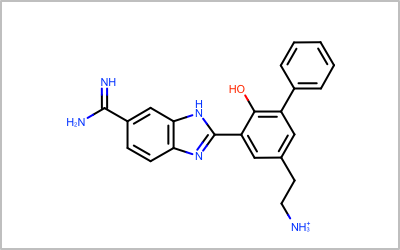
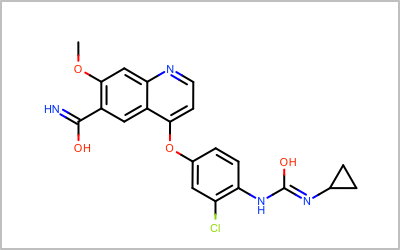
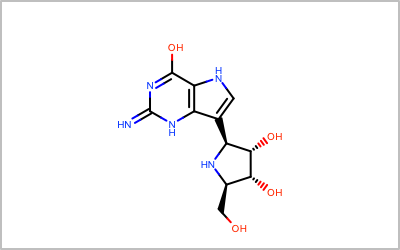
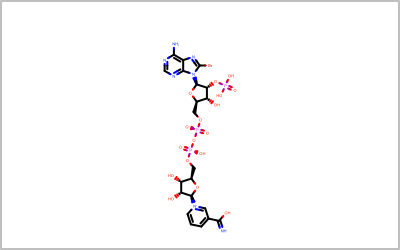
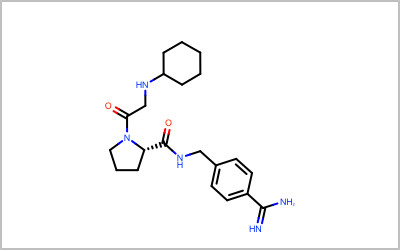
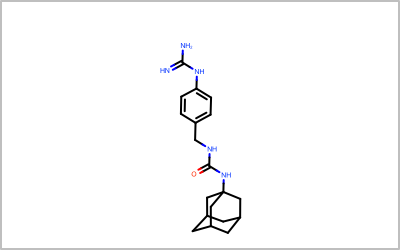
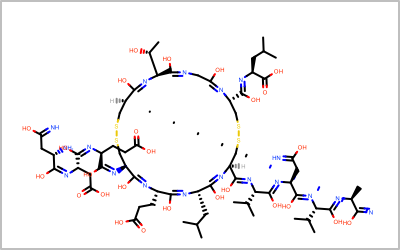
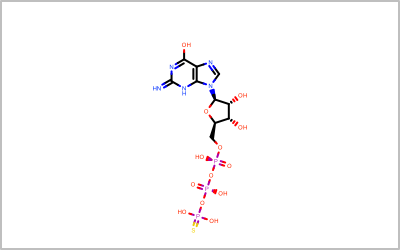
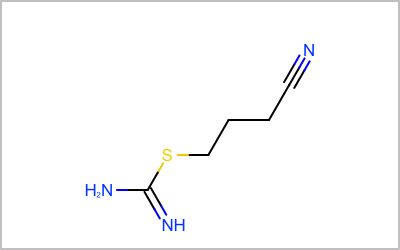
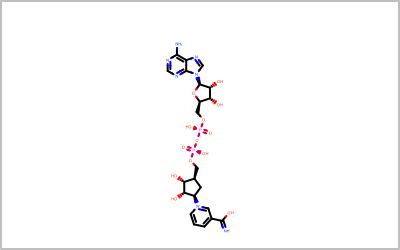
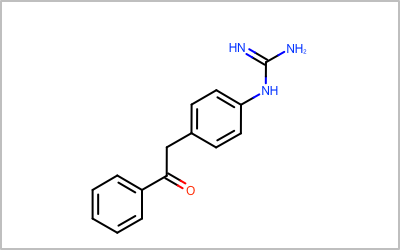
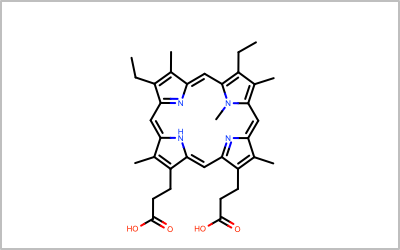
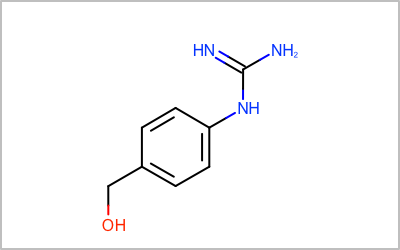
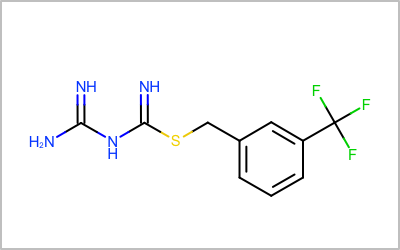
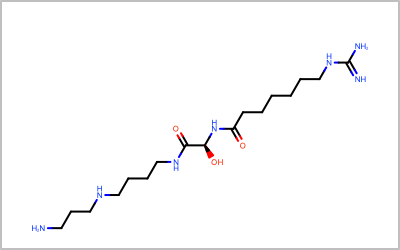
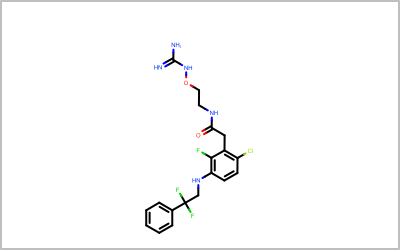
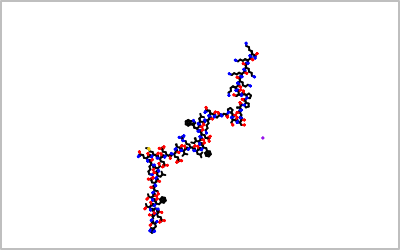
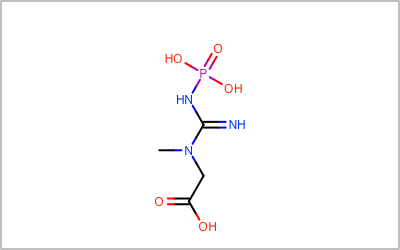
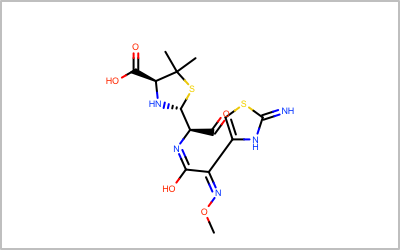

In [66]:
def to_molecule(smiles):
    oemol = oechem.OEMol()
    oechem.OESmilesToMol(oemol, smiles)
    return oemol
d = dict()
d['smiles'] = still_problematic_oe
df = pd.DataFrame(d)
df['Molecule'] = df.smiles.apply(to_molecule)
df = df.drop(['smiles'], axis=1)
oenb.render_dataframe(df)


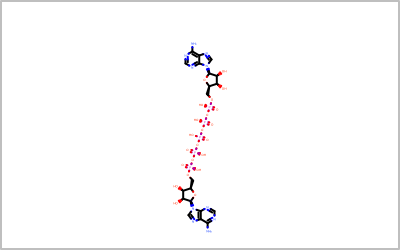
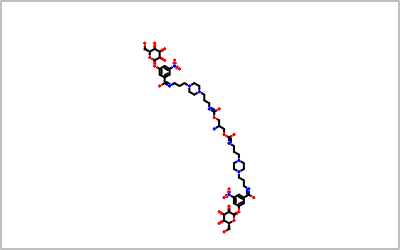
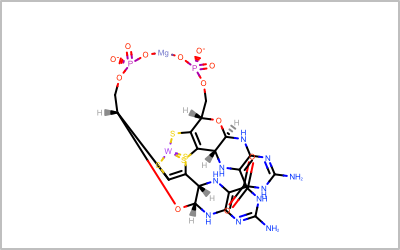
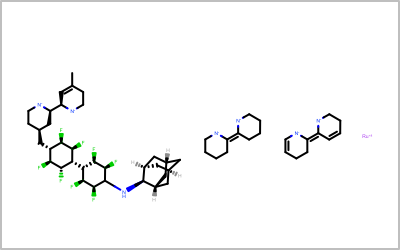
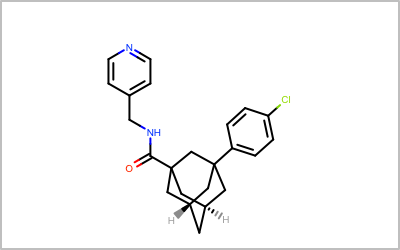
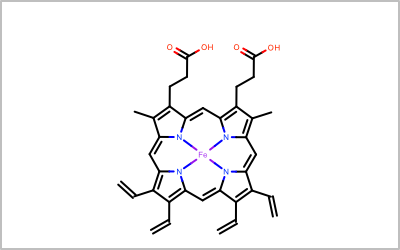
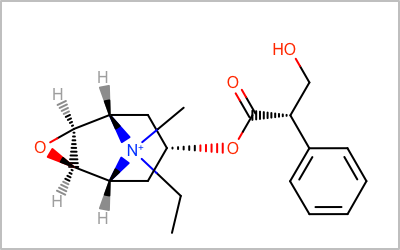
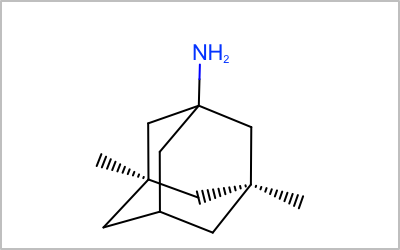
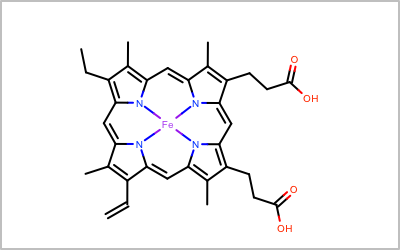
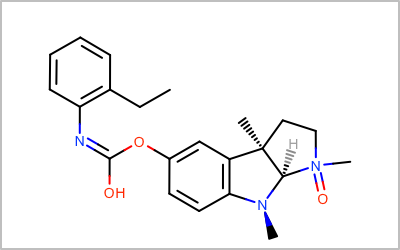
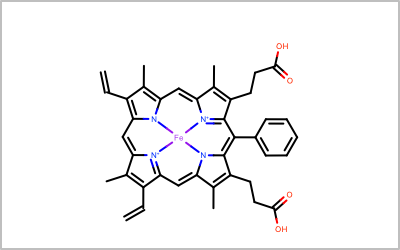
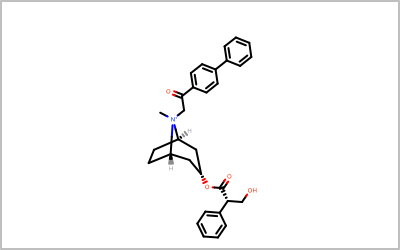
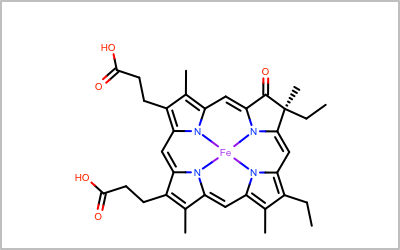
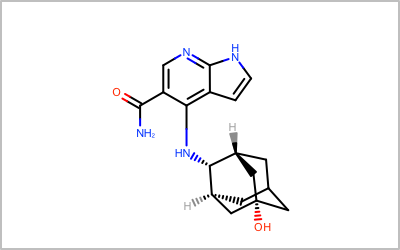
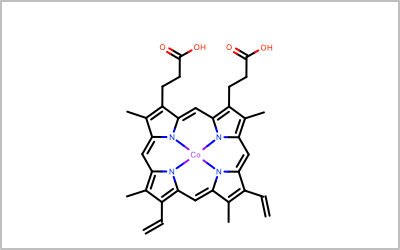
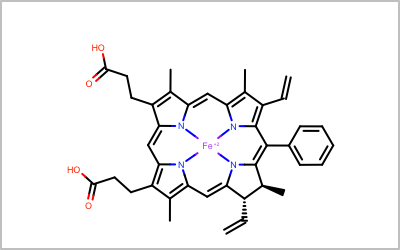
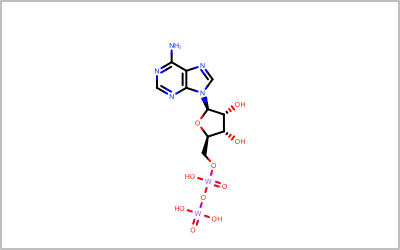
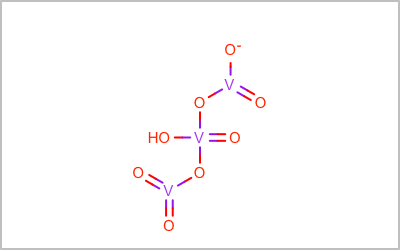
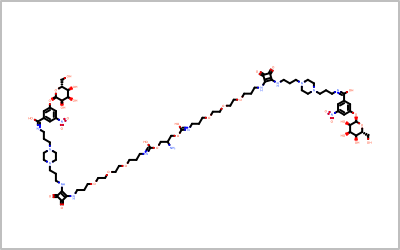
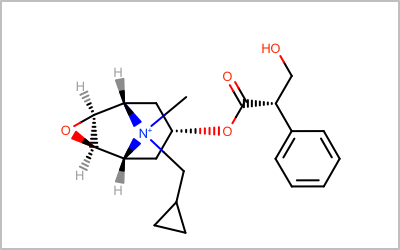
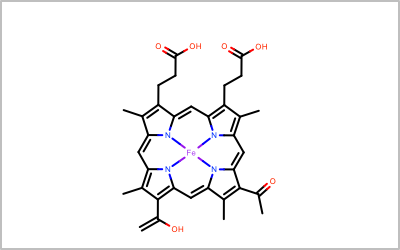
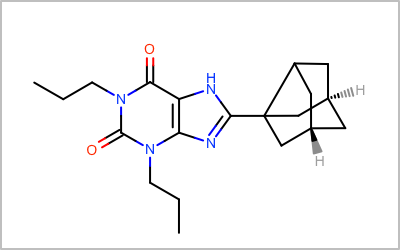
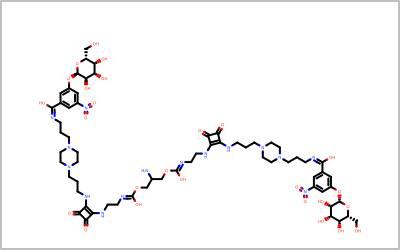
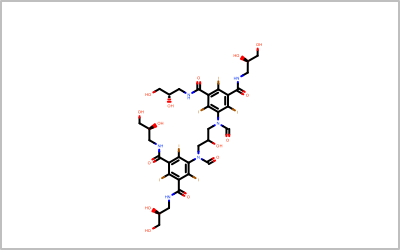
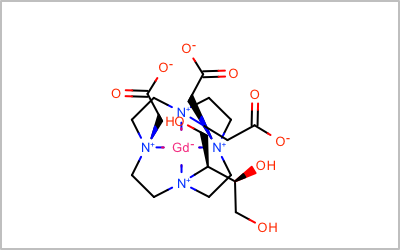
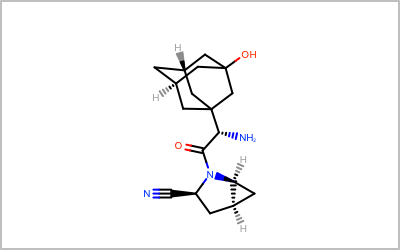
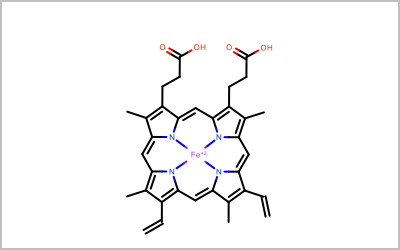
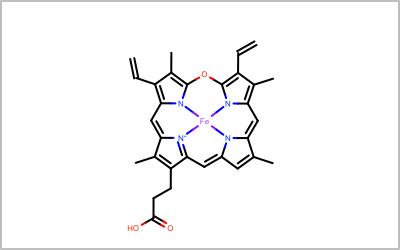
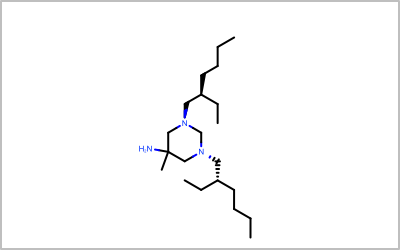
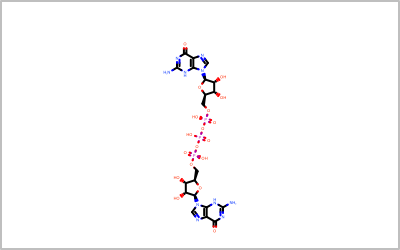
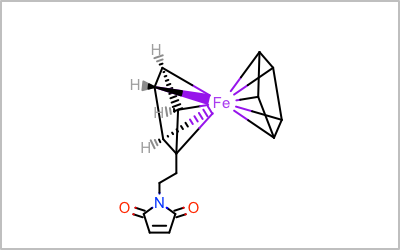
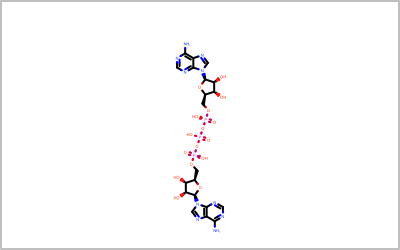
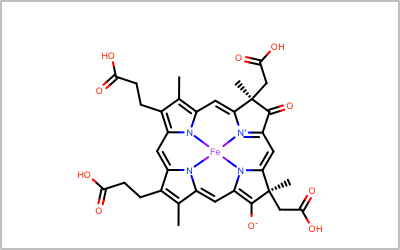
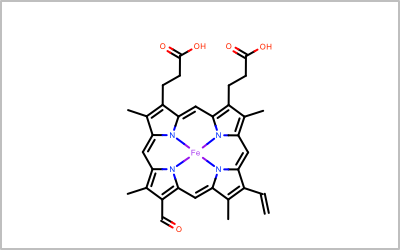
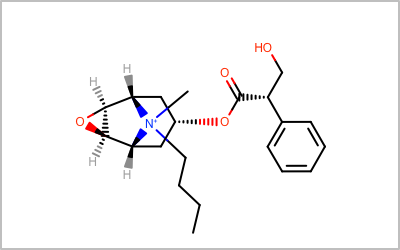
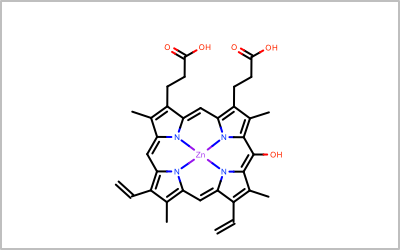
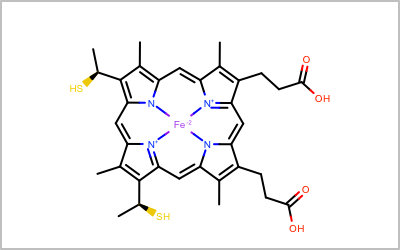

In [67]:
def to_molecule(smiles):
    oemol = oechem.OEMol()
    oechem.OESmilesToMol(oemol, smiles)
    return oemol
d = dict()
d['smiles'] = still_problematic_rd
df = pd.DataFrame(d)
df['Molecule'] = df.smiles.apply(to_molecule)
df = df.drop(['smiles'], axis=1)
oenb.render_dataframe(df)

c1ccc(cc1)C[C@H](C(=[OH+])C[N+]#N)[N-]C(=O)OCc2ccccc2


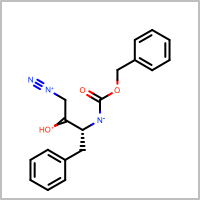

In [70]:
print(still_problematic_oe[52])
oenb.draw_smiles(still_problematic_oe[52])